In [15]:
import pandas as pd
import numpy as np
from readFile import split_into_values, toRPdata
# columns 와 value는 사용자 입력
# df = pd.read_csv('resources/AXISX_resample.csv')
df = pd.read_csv('resources/CLAMP_resample.csv')
columns = ['chip', 'wire', 'segment']
value = ['value']
#df = pd.read_csv('resources/Dataset1.csv')
#columns = ['Process', 'Step']
#value = ['Value']

df = df.loc[:, columns + value] #('chip', 'wire', 'value')는 사용자 입력
size = 256
result = split_into_values(df, columns)

# dataframe -> list
result_list = result.values.tolist()

from sklearn.preprocessing import MinMaxScaler

def MinMax(data):
    MMS = MinMaxScaler().fit(data)
    scaled = MMS.transform(data)
    return scaled

# result_list transpose
result_T = [list(x) for x in zip(*result_list)]

# minmax 정규화
result_scaled = MinMax(result_T)

# 다시 result transpose 해서 원래대로
result_scaled = [list(x) for x in zip(*result_scaled)]

from tslearn.preprocessing import TimeSeriesScalerMeanVariance, TimeSeriesResampler

# 2. 시계열 셋 크기 변경
#result_ = TimeSeriesResampler(sz=size).fit_transform(result)

In [16]:
# 2. 시계열 셋 크기 변경
result_ = TimeSeriesResampler(sz=size).fit_transform(result_scaled)

result_.shape

(1140, 256, 1)

In [2]:
data = result_.reshape(result_.shape[0], 1, size)
X = toRPdata(data, threshold='point', percentage=30)
#X = toRPdata(data)
    
X_scaled = np.expand_dims(X, axis=3)
X_scaled.shape

(1140, 28, 28, 1)

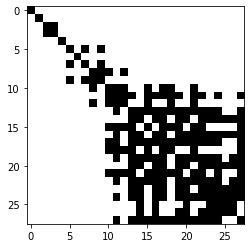

In [3]:
from matplotlib import pyplot as plt
plt.imshow(X[0], cmap='Greys')

In [18]:
#you will use a batch size of 128 using a higher batch size of 256 or 512 is also preferable
batch_size = 128
learning_rate = 0.0001
epochs = 5000
optimizer='Adam'
loss='mse'

In [19]:
from utils import split_data, normalization_tool
from agent import Autoencoder_Agent
from utils import optimizer_set
from keras.models import Sequential
from keras.layers import Dropout, Activation, Dense
from keras.layers.convolutional import Conv2D, MaxPooling2D, UpSampling2D

#lr 바뀔때는 실행하지 말것! 새로운 rp 적용할때는 한번 적용!
#X_train, X_test, Y_train, Y_test = split_data(X_scaled, X_scaled) #데이터 분리

optimizer = optimizer_set(optimizer, learning_rate)
model = Sequential()
 
#1st convolution layer
model.add(Conv2D(16, (3, 3) #16 is number of filters and (3, 3) is the size of the filter.
, padding='same', input_shape=(28,28,1)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2), padding='same'))

#2nd convolution layer
model.add(Conv2D(2,(3, 3), padding='same')) # apply 2 filters sized of (3x3)
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2), padding='same'))

#here compressed version

#3rd convolution layer
model.add(Conv2D(2,(3, 3), padding='same')) # apply 2 filters sized of (3x3)
model.add(Activation('relu'))
model.add(UpSampling2D((2, 2)))

#4rd convolution layer
model.add(Conv2D(16,(3, 3), padding='same'))
model.add(Activation('relu'))
model.add(UpSampling2D((2, 2)))

model.add(Conv2D(1,(3, 3), padding='same'))
model.add(Activation('sigmoid'))
model.summary()


model.compile(optimizer=optimizer, loss=loss) #사용자 지정 파라미터(optimizer, loss)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 28, 28, 16)        160       
_________________________________________________________________
activation_10 (Activation)   (None, 28, 28, 16)        0         
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 14, 14, 2)         290       
_________________________________________________________________
activation_11 (Activation)   (None, 14, 14, 2)         0         
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 7, 7, 2)           0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 7, 7, 2)          

In [20]:
from keras.callbacks import EarlyStopping, ModelCheckpoint

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=100, min_delta=0.0001)
mc = ModelCheckpoint(f'CLAMP28_0.001_Autoencoder_weight.h5', monitor='val_loss', verbose=1, save_best_only=True)

In [21]:
new_hist = model.fit(X_train, X_train,
          batch_size = batch_size,epochs=epochs,
          validation_data=(X_test,X_test),callbacks=[es, mc]
         )

Epoch 1/5000
7/7 [==============================] - ETA: 0s - loss: 0.2503
Epoch 00001: val_loss improved from inf to 0.25002, saving model to CLAMP28_0.001_Autoencoder_weight.h5
7/7 [==============================] - 1s 107ms/step - loss: 0.2503 - val_loss: 0.2500
Epoch 2/5000
7/7 [==============================] - ETA: 0s - loss: 0.2499
Epoch 00002: val_loss improved from 0.25002 to 0.24965, saving model to CLAMP28_0.001_Autoencoder_weight.h5
7/7 [==============================] - 1s 95ms/step - loss: 0.2499 - val_loss: 0.2497
Epoch 3/5000
7/7 [==============================] - ETA: 0s - loss: 0.2495
Epoch 00003: val_loss improved from 0.24965 to 0.24931, saving model to CLAMP28_0.001_Autoencoder_weight.h5
7/7 [==============================] - 1s 97ms/step - loss: 0.2495 - val_loss: 0.2493
Epoch 4/5000
7/7 [==============================] - ETA: 0s - loss: 0.2492
Epoch 00004: val_loss improved from 0.24931 to 0.24897, saving model to CLAMP28_0.001_Autoencoder_weight.h5
7/7 [========

Epoch 32/5000
7/7 [==============================] - ETA: 0s - loss: 0.2364
Epoch 00032: val_loss improved from 0.23665 to 0.23602, saving model to CLAMP28_0.001_Autoencoder_weight.h5
7/7 [==============================] - 1s 92ms/step - loss: 0.2364 - val_loss: 0.2360
Epoch 33/5000
7/7 [==============================] - ETA: 0s - loss: 0.2358
Epoch 00033: val_loss improved from 0.23602 to 0.23536, saving model to CLAMP28_0.001_Autoencoder_weight.h5
7/7 [==============================] - 1s 92ms/step - loss: 0.2358 - val_loss: 0.2354
Epoch 34/5000
7/7 [==============================] - ETA: 0s - loss: 0.2351
Epoch 00034: val_loss improved from 0.23536 to 0.23466, saving model to CLAMP28_0.001_Autoencoder_weight.h5
7/7 [==============================] - 1s 90ms/step - loss: 0.2351 - val_loss: 0.2347
Epoch 35/5000
7/7 [==============================] - ETA: 0s - loss: 0.2344
Epoch 00035: val_loss improved from 0.23466 to 0.23393, saving model to CLAMP28_0.001_Autoencoder_weight.h5
7/7 [=

Epoch 93/5000
7/7 [==============================] - ETA: 0s - loss: 0.1784
Epoch 00093: val_loss improved from 0.17821 to 0.17761, saving model to CLAMP28_0.001_Autoencoder_weight.h5
7/7 [==============================] - 1s 91ms/step - loss: 0.1784 - val_loss: 0.1776
Epoch 94/5000
7/7 [==============================] - ETA: 0s - loss: 0.1778
Epoch 00094: val_loss improved from 0.17761 to 0.17700, saving model to CLAMP28_0.001_Autoencoder_weight.h5
7/7 [==============================] - 1s 93ms/step - loss: 0.1778 - val_loss: 0.1770
Epoch 95/5000
7/7 [==============================] - ETA: 0s - loss: 0.1772
Epoch 00095: val_loss improved from 0.17700 to 0.17638, saving model to CLAMP28_0.001_Autoencoder_weight.h5
7/7 [==============================] - 1s 85ms/step - loss: 0.1772 - val_loss: 0.1764
Epoch 96/5000
7/7 [==============================] - ETA: 0s - loss: 0.1766
Epoch 00096: val_loss improved from 0.17638 to 0.17571, saving model to CLAMP28_0.001_Autoencoder_weight.h5
7/7 [=

Epoch 154/5000
7/7 [==============================] - ETA: 0s - loss: 0.1419
Epoch 00154: val_loss improved from 0.14142 to 0.14108, saving model to CLAMP28_0.001_Autoencoder_weight.h5
7/7 [==============================] - 1s 89ms/step - loss: 0.1419 - val_loss: 0.1411
Epoch 155/5000
7/7 [==============================] - ETA: 0s - loss: 0.1416
Epoch 00155: val_loss improved from 0.14108 to 0.14074, saving model to CLAMP28_0.001_Autoencoder_weight.h5
7/7 [==============================] - 1s 96ms/step - loss: 0.1416 - val_loss: 0.1407
Epoch 156/5000
7/7 [==============================] - ETA: 0s - loss: 0.1412
Epoch 00156: val_loss improved from 0.14074 to 0.14042, saving model to CLAMP28_0.001_Autoencoder_weight.h5
7/7 [==============================] - 1s 98ms/step - loss: 0.1412 - val_loss: 0.1404
Epoch 157/5000
7/7 [==============================] - ETA: 0s - loss: 0.1409
Epoch 00157: val_loss improved from 0.14042 to 0.14010, saving model to CLAMP28_0.001_Autoencoder_weight.h5
7/

Epoch 215/5000
7/7 [==============================] - ETA: 0s - loss: 0.1301
Epoch 00215: val_loss improved from 0.12974 to 0.12964, saving model to CLAMP28_0.001_Autoencoder_weight.h5
7/7 [==============================] - 1s 92ms/step - loss: 0.1301 - val_loss: 0.1296
Epoch 216/5000
7/7 [==============================] - ETA: 0s - loss: 0.1300
Epoch 00216: val_loss improved from 0.12964 to 0.12953, saving model to CLAMP28_0.001_Autoencoder_weight.h5
7/7 [==============================] - 1s 89ms/step - loss: 0.1300 - val_loss: 0.1295
Epoch 217/5000
7/7 [==============================] - ETA: 0s - loss: 0.1299
Epoch 00217: val_loss improved from 0.12953 to 0.12942, saving model to CLAMP28_0.001_Autoencoder_weight.h5
7/7 [==============================] - 1s 91ms/step - loss: 0.1299 - val_loss: 0.1294
Epoch 218/5000
7/7 [==============================] - ETA: 0s - loss: 0.1297
Epoch 00218: val_loss improved from 0.12942 to 0.12932, saving model to CLAMP28_0.001_Autoencoder_weight.h5
7/

7/7 [==============================] - ETA: 0s - loss: 0.1241
Epoch 00275: val_loss improved from 0.12374 to 0.12366, saving model to CLAMP28_0.001_Autoencoder_weight.h5
7/7 [==============================] - 1s 91ms/step - loss: 0.1241 - val_loss: 0.1237
Epoch 276/5000
7/7 [==============================] - ETA: 0s - loss: 0.1240
Epoch 00276: val_loss improved from 0.12366 to 0.12359, saving model to CLAMP28_0.001_Autoencoder_weight.h5
7/7 [==============================] - 1s 88ms/step - loss: 0.1240 - val_loss: 0.1236
Epoch 277/5000
7/7 [==============================] - ETA: 0s - loss: 0.1240
Epoch 00277: val_loss improved from 0.12359 to 0.12352, saving model to CLAMP28_0.001_Autoencoder_weight.h5
7/7 [==============================] - 1s 91ms/step - loss: 0.1240 - val_loss: 0.1235
Epoch 278/5000
7/7 [==============================] - ETA: 0s - loss: 0.1239
Epoch 00278: val_loss improved from 0.12352 to 0.12345, saving model to CLAMP28_0.001_Autoencoder_weight.h5
7/7 [============

Epoch 306/5000
7/7 [==============================] - ETA: 0s - loss: 0.1221
Epoch 00306: val_loss improved from 0.12173 to 0.12168, saving model to CLAMP28_0.001_Autoencoder_weight.h5
7/7 [==============================] - 1s 89ms/step - loss: 0.1221 - val_loss: 0.1217
Epoch 307/5000
7/7 [==============================] - ETA: 0s - loss: 0.1221
Epoch 00307: val_loss improved from 0.12168 to 0.12161, saving model to CLAMP28_0.001_Autoencoder_weight.h5
7/7 [==============================] - 1s 90ms/step - loss: 0.1221 - val_loss: 0.1216
Epoch 308/5000
7/7 [==============================] - ETA: 0s - loss: 0.1220
Epoch 00308: val_loss improved from 0.12161 to 0.12155, saving model to CLAMP28_0.001_Autoencoder_weight.h5
7/7 [==============================] - 1s 90ms/step - loss: 0.1220 - val_loss: 0.1216
Epoch 309/5000
7/7 [==============================] - ETA: 0s - loss: 0.1220
Epoch 00309: val_loss improved from 0.12155 to 0.12150, saving model to CLAMP28_0.001_Autoencoder_weight.h5
7/

7/7 [==============================] - ETA: 0s - loss: 0.1195
Epoch 00366: val_loss improved from 0.11895 to 0.11891, saving model to CLAMP28_0.001_Autoencoder_weight.h5
7/7 [==============================] - 1s 97ms/step - loss: 0.1195 - val_loss: 0.1189
Epoch 367/5000
7/7 [==============================] - ETA: 0s - loss: 0.1194
Epoch 00367: val_loss improved from 0.11891 to 0.11887, saving model to CLAMP28_0.001_Autoencoder_weight.h5
7/7 [==============================] - 1s 120ms/step - loss: 0.1194 - val_loss: 0.1189
Epoch 368/5000
7/7 [==============================] - ETA: 0s - loss: 0.1194
Epoch 00368: val_loss improved from 0.11887 to 0.11884, saving model to CLAMP28_0.001_Autoencoder_weight.h5
7/7 [==============================] - 1s 100ms/step - loss: 0.1194 - val_loss: 0.1188
Epoch 369/5000
7/7 [==============================] - ETA: 0s - loss: 0.1193
Epoch 00369: val_loss improved from 0.11884 to 0.11880, saving model to CLAMP28_0.001_Autoencoder_weight.h5
7/7 [==========

Epoch 427/5000
7/7 [==============================] - ETA: 0s - loss: 0.1177
Epoch 00427: val_loss improved from 0.11716 to 0.11715, saving model to CLAMP28_0.001_Autoencoder_weight.h5
7/7 [==============================] - 1s 85ms/step - loss: 0.1177 - val_loss: 0.1171
Epoch 428/5000
7/7 [==============================] - ETA: 0s - loss: 0.1177
Epoch 00428: val_loss improved from 0.11715 to 0.11711, saving model to CLAMP28_0.001_Autoencoder_weight.h5
7/7 [==============================] - 1s 90ms/step - loss: 0.1177 - val_loss: 0.1171
Epoch 429/5000
7/7 [==============================] - ETA: 0s - loss: 0.1176
Epoch 00429: val_loss improved from 0.11711 to 0.11709, saving model to CLAMP28_0.001_Autoencoder_weight.h5
7/7 [==============================] - 1s 92ms/step - loss: 0.1176 - val_loss: 0.1171
Epoch 430/5000
7/7 [==============================] - ETA: 0s - loss: 0.1176- ETA: 0s - loss: 0
Epoch 00430: val_loss improved from 0.11709 to 0.11707, saving model to CLAMP28_0.001_Autoe

Epoch 458/5000
7/7 [==============================] - ETA: 0s - loss: 0.1170
Epoch 00458: val_loss improved from 0.11646 to 0.11644, saving model to CLAMP28_0.001_Autoencoder_weight.h5
7/7 [==============================] - 1s 90ms/step - loss: 0.1170 - val_loss: 0.1164
Epoch 459/5000
7/7 [==============================] - ETA: 0s - loss: 0.1170
Epoch 00459: val_loss improved from 0.11644 to 0.11642, saving model to CLAMP28_0.001_Autoencoder_weight.h5
7/7 [==============================] - 1s 90ms/step - loss: 0.1170 - val_loss: 0.1164
Epoch 460/5000
7/7 [==============================] - ETA: 0s - loss: 0.1169
Epoch 00460: val_loss improved from 0.11642 to 0.11640, saving model to CLAMP28_0.001_Autoencoder_weight.h5
7/7 [==============================] - 1s 89ms/step - loss: 0.1169 - val_loss: 0.1164
Epoch 461/5000
7/7 [==============================] - ETA: 0s - loss: 0.1169
Epoch 00461: val_loss improved from 0.11640 to 0.11638, saving model to CLAMP28_0.001_Autoencoder_weight.h5
7/

Epoch 489/5000
7/7 [==============================] - ETA: 0s - loss: 0.1163
Epoch 00489: val_loss did not improve from 0.11580
7/7 [==============================] - 1s 87ms/step - loss: 0.1163 - val_loss: 0.1158
Epoch 490/5000
7/7 [==============================] - ETA: 0s - loss: 0.1163
Epoch 00490: val_loss improved from 0.11580 to 0.11576, saving model to CLAMP28_0.001_Autoencoder_weight.h5
7/7 [==============================] - 1s 90ms/step - loss: 0.1163 - val_loss: 0.1158
Epoch 491/5000
7/7 [==============================] - ETA: 0s - loss: 0.1163
Epoch 00491: val_loss improved from 0.11576 to 0.11574, saving model to CLAMP28_0.001_Autoencoder_weight.h5
7/7 [==============================] - 1s 90ms/step - loss: 0.1163 - val_loss: 0.1157
Epoch 492/5000
7/7 [==============================] - ETA: 0s - loss: 0.1163
Epoch 00492: val_loss improved from 0.11574 to 0.11572, saving model to CLAMP28_0.001_Autoencoder_weight.h5
7/7 [==============================] - 1s 91ms/step - loss:

Epoch 520/5000
7/7 [==============================] - ETA: 0s - loss: 0.1157
Epoch 00520: val_loss improved from 0.11516 to 0.11515, saving model to CLAMP28_0.001_Autoencoder_weight.h5
7/7 [==============================] - 1s 94ms/step - loss: 0.1157 - val_loss: 0.1151
Epoch 521/5000
7/7 [==============================] - ETA: 0s - loss: 0.1157
Epoch 00521: val_loss improved from 0.11515 to 0.11511, saving model to CLAMP28_0.001_Autoencoder_weight.h5
7/7 [==============================] - 1s 93ms/step - loss: 0.1157 - val_loss: 0.1151
Epoch 522/5000
7/7 [==============================] - ETA: 0s - loss: 0.1156
Epoch 00522: val_loss improved from 0.11511 to 0.11510, saving model to CLAMP28_0.001_Autoencoder_weight.h5
7/7 [==============================] - 1s 88ms/step - loss: 0.1156 - val_loss: 0.1151
Epoch 523/5000
7/7 [==============================] - ETA: 0s - loss: 0.1156
Epoch 00523: val_loss improved from 0.11510 to 0.11508, saving model to CLAMP28_0.001_Autoencoder_weight.h5
7/

7/7 [==============================] - 1s 94ms/step - loss: 0.1144 - val_loss: 0.1139
Epoch 581/5000
7/7 [==============================] - ETA: 0s - loss: 0.1144
Epoch 00581: val_loss improved from 0.11385 to 0.11384, saving model to CLAMP28_0.001_Autoencoder_weight.h5
7/7 [==============================] - 1s 93ms/step - loss: 0.1144 - val_loss: 0.1138
Epoch 582/5000
7/7 [==============================] - ETA: 0s - loss: 0.1144
Epoch 00582: val_loss improved from 0.11384 to 0.11381, saving model to CLAMP28_0.001_Autoencoder_weight.h5
7/7 [==============================] - 1s 90ms/step - loss: 0.1144 - val_loss: 0.1138
Epoch 583/5000
7/7 [==============================] - ETA: 0s - loss: 0.1143
Epoch 00583: val_loss improved from 0.11381 to 0.11379, saving model to CLAMP28_0.001_Autoencoder_weight.h5
7/7 [==============================] - 1s 91ms/step - loss: 0.1143 - val_loss: 0.1138
Epoch 584/5000
7/7 [==============================] - ETA: 0s - loss: 0.1143
Epoch 00584: val_loss im

Epoch 611/5000
7/7 [==============================] - ETA: 0s - loss: 0.1137
Epoch 00611: val_loss improved from 0.11317 to 0.11315, saving model to CLAMP28_0.001_Autoencoder_weight.h5
7/7 [==============================] - 1s 91ms/step - loss: 0.1137 - val_loss: 0.1131
Epoch 612/5000
7/7 [==============================] - ETA: 0s - loss: 0.1137
Epoch 00612: val_loss improved from 0.11315 to 0.11313, saving model to CLAMP28_0.001_Autoencoder_weight.h5
7/7 [==============================] - 1s 92ms/step - loss: 0.1137 - val_loss: 0.1131
Epoch 613/5000
7/7 [==============================] - ETA: 0s - loss: 0.1137
Epoch 00613: val_loss improved from 0.11313 to 0.11311, saving model to CLAMP28_0.001_Autoencoder_weight.h5
7/7 [==============================] - 1s 93ms/step - loss: 0.1137 - val_loss: 0.1131
Epoch 614/5000
7/7 [==============================] - ETA: 0s - loss: 0.1136
Epoch 00614: val_loss improved from 0.11311 to 0.11308, saving model to CLAMP28_0.001_Autoencoder_weight.h5
7/

Epoch 642/5000
7/7 [==============================] - ETA: 0s - loss: 0.1130
Epoch 00642: val_loss improved from 0.11247 to 0.11245, saving model to CLAMP28_0.001_Autoencoder_weight.h5
7/7 [==============================] - 1s 94ms/step - loss: 0.1130 - val_loss: 0.1125
Epoch 643/5000
7/7 [==============================] - ETA: 0s - loss: 0.1130
Epoch 00643: val_loss improved from 0.11245 to 0.11242, saving model to CLAMP28_0.001_Autoencoder_weight.h5
7/7 [==============================] - 1s 91ms/step - loss: 0.1130 - val_loss: 0.1124
Epoch 644/5000
7/7 [==============================] - ETA: 0s - loss: 0.1130
Epoch 00644: val_loss improved from 0.11242 to 0.11240, saving model to CLAMP28_0.001_Autoencoder_weight.h5
7/7 [==============================] - 1s 90ms/step - loss: 0.1130 - val_loss: 0.1124
Epoch 645/5000
7/7 [==============================] - ETA: 0s - loss: 0.1130
Epoch 00645: val_loss improved from 0.11240 to 0.11240, saving model to CLAMP28_0.001_Autoencoder_weight.h5
7/

Epoch 703/5000
7/7 [==============================] - ETA: 0s - loss: 0.1118
Epoch 00703: val_loss improved from 0.11127 to 0.11126, saving model to CLAMP28_0.001_Autoencoder_weight.h5
7/7 [==============================] - 1s 92ms/step - loss: 0.1118 - val_loss: 0.1113
Epoch 704/5000
7/7 [==============================] - ETA: 0s - loss: 0.1118
Epoch 00704: val_loss improved from 0.11126 to 0.11124, saving model to CLAMP28_0.001_Autoencoder_weight.h5
7/7 [==============================] - 1s 88ms/step - loss: 0.1118 - val_loss: 0.1112
Epoch 705/5000
7/7 [==============================] - ETA: 0s - loss: 0.1118
Epoch 00705: val_loss improved from 0.11124 to 0.11122, saving model to CLAMP28_0.001_Autoencoder_weight.h5
7/7 [==============================] - 1s 92ms/step - loss: 0.1118 - val_loss: 0.1112
Epoch 706/5000
7/7 [==============================] - ETA: 0s - loss: 0.1117
Epoch 00706: val_loss improved from 0.11122 to 0.11120, saving model to CLAMP28_0.001_Autoencoder_weight.h5
7/

Epoch 765/5000
7/7 [==============================] - ETA: 0s - loss: 0.1108
Epoch 00765: val_loss improved from 0.11026 to 0.11024, saving model to CLAMP28_0.001_Autoencoder_weight.h5
7/7 [==============================] - 1s 88ms/step - loss: 0.1108 - val_loss: 0.1102
Epoch 766/5000
7/7 [==============================] - ETA: 0s - loss: 0.1107
Epoch 00766: val_loss improved from 0.11024 to 0.11023, saving model to CLAMP28_0.001_Autoencoder_weight.h5
7/7 [==============================] - 1s 91ms/step - loss: 0.1107 - val_loss: 0.1102
Epoch 767/5000
7/7 [==============================] - ETA: 0s - loss: 0.1107
Epoch 00767: val_loss improved from 0.11023 to 0.11022, saving model to CLAMP28_0.001_Autoencoder_weight.h5
7/7 [==============================] - 1s 97ms/step - loss: 0.1107 - val_loss: 0.1102
Epoch 768/5000
7/7 [==============================] - ETA: 0s - loss: 0.1107
Epoch 00768: val_loss improved from 0.11022 to 0.11019, saving model to CLAMP28_0.001_Autoencoder_weight.h5
7/

Epoch 796/5000
7/7 [==============================] - ETA: 0s - loss: 0.1103
Epoch 00796: val_loss improved from 0.10980 to 0.10979, saving model to CLAMP28_0.001_Autoencoder_weight.h5
7/7 [==============================] - 1s 95ms/step - loss: 0.1103 - val_loss: 0.1098
Epoch 797/5000
7/7 [==============================] - ETA: 0s - loss: 0.1103
Epoch 00797: val_loss improved from 0.10979 to 0.10977, saving model to CLAMP28_0.001_Autoencoder_weight.h5
7/7 [==============================] - 1s 92ms/step - loss: 0.1103 - val_loss: 0.1098
Epoch 798/5000
7/7 [==============================] - ETA: 0s - loss: 0.1103
Epoch 00798: val_loss improved from 0.10977 to 0.10976, saving model to CLAMP28_0.001_Autoencoder_weight.h5
7/7 [==============================] - 1s 90ms/step - loss: 0.1103 - val_loss: 0.1098
Epoch 799/5000
7/7 [==============================] - ETA: 0s - loss: 0.1103
Epoch 00799: val_loss improved from 0.10976 to 0.10975, saving model to CLAMP28_0.001_Autoencoder_weight.h5
7/

Epoch 827/5000
7/7 [==============================] - ETA: 0s - loss: 0.1099
Epoch 00827: val_loss did not improve from 0.10938
7/7 [==============================] - 1s 88ms/step - loss: 0.1099 - val_loss: 0.1094
Epoch 828/5000
7/7 [==============================] - ETA: 0s - loss: 0.1099
Epoch 00828: val_loss improved from 0.10938 to 0.10935, saving model to CLAMP28_0.001_Autoencoder_weight.h5
7/7 [==============================] - 1s 92ms/step - loss: 0.1099 - val_loss: 0.1094
Epoch 829/5000
7/7 [==============================] - ETA: 0s - loss: 0.1098
Epoch 00829: val_loss improved from 0.10935 to 0.10934, saving model to CLAMP28_0.001_Autoencoder_weight.h5
7/7 [==============================] - 1s 86ms/step - loss: 0.1098 - val_loss: 0.1093
Epoch 830/5000
7/7 [==============================] - ETA: 0s - loss: 0.1098
Epoch 00830: val_loss improved from 0.10934 to 0.10933, saving model to CLAMP28_0.001_Autoencoder_weight.h5
7/7 [==============================] - 1s 89ms/step - loss:

Epoch 889/5000
7/7 [==============================] - ETA: 0s - loss: 0.1090
Epoch 00889: val_loss improved from 0.10852 to 0.10852, saving model to CLAMP28_0.001_Autoencoder_weight.h5
7/7 [==============================] - 1s 92ms/step - loss: 0.1090 - val_loss: 0.1085
Epoch 890/5000
7/7 [==============================] - ETA: 0s - loss: 0.1090- ETA: 0s - loss: 0.109
Epoch 00890: val_loss improved from 0.10852 to 0.10849, saving model to CLAMP28_0.001_Autoencoder_weight.h5
7/7 [==============================] - 1s 91ms/step - loss: 0.1090 - val_loss: 0.1085
Epoch 891/5000
7/7 [==============================] - ETA: 0s - loss: 0.1090
Epoch 00891: val_loss improved from 0.10849 to 0.10847, saving model to CLAMP28_0.001_Autoencoder_weight.h5
7/7 [==============================] - 1s 95ms/step - loss: 0.1090 - val_loss: 0.1085
Epoch 892/5000
7/7 [==============================] - ETA: 0s - loss: 0.1090
Epoch 00892: val_loss improved from 0.10847 to 0.10847, saving model to CLAMP28_0.001_A

Epoch 920/5000
7/7 [==============================] - ETA: 0s - loss: 0.1086
Epoch 00920: val_loss did not improve from 0.10813
7/7 [==============================] - 1s 93ms/step - loss: 0.1086 - val_loss: 0.1081
Epoch 921/5000
7/7 [==============================] - ETA: 0s - loss: 0.1086
Epoch 00921: val_loss improved from 0.10813 to 0.10810, saving model to CLAMP28_0.001_Autoencoder_weight.h5
7/7 [==============================] - 1s 88ms/step - loss: 0.1086 - val_loss: 0.1081
Epoch 922/5000
7/7 [==============================] - ETA: 0s - loss: 0.1086
Epoch 00922: val_loss improved from 0.10810 to 0.10809, saving model to CLAMP28_0.001_Autoencoder_weight.h5
7/7 [==============================] - 1s 93ms/step - loss: 0.1086 - val_loss: 0.1081
Epoch 923/5000
7/7 [==============================] - ETA: 0s - loss: 0.1086
Epoch 00923: val_loss improved from 0.10809 to 0.10808, saving model to CLAMP28_0.001_Autoencoder_weight.h5
7/7 [==============================] - 1s 95ms/step - loss:

Epoch 951/5000
7/7 [==============================] - ETA: 0s - loss: 0.1082
Epoch 00951: val_loss improved from 0.10777 to 0.10775, saving model to CLAMP28_0.001_Autoencoder_weight.h5
7/7 [==============================] - 1s 101ms/step - loss: 0.1082 - val_loss: 0.1077
Epoch 952/5000
7/7 [==============================] - ETA: 0s - loss: 0.1082
Epoch 00952: val_loss did not improve from 0.10775
7/7 [==============================] - 1s 92ms/step - loss: 0.1082 - val_loss: 0.1078
Epoch 953/5000
7/7 [==============================] - ETA: 0s - loss: 0.1082
Epoch 00953: val_loss improved from 0.10775 to 0.10773, saving model to CLAMP28_0.001_Autoencoder_weight.h5
7/7 [==============================] - 1s 91ms/step - loss: 0.1082 - val_loss: 0.1077
Epoch 954/5000
7/7 [==============================] - ETA: 0s - loss: 0.1082
Epoch 00954: val_loss improved from 0.10773 to 0.10772, saving model to CLAMP28_0.001_Autoencoder_weight.h5
7/7 [==============================] - 1s 95ms/step - loss

Epoch 1013/5000
7/7 [==============================] - ETA: 0s - loss: 0.1075
Epoch 01013: val_loss improved from 0.10713 to 0.10711, saving model to CLAMP28_0.001_Autoencoder_weight.h5
7/7 [==============================] - 1s 97ms/step - loss: 0.1075 - val_loss: 0.1071
Epoch 1014/5000
7/7 [==============================] - ETA: 0s - loss: 0.1075
Epoch 01014: val_loss improved from 0.10711 to 0.10711, saving model to CLAMP28_0.001_Autoencoder_weight.h5
7/7 [==============================] - 1s 95ms/step - loss: 0.1075 - val_loss: 0.1071
Epoch 1015/5000
7/7 [==============================] - ETA: 0s - loss: 0.1075
Epoch 01015: val_loss improved from 0.10711 to 0.10711, saving model to CLAMP28_0.001_Autoencoder_weight.h5
7/7 [==============================] - 1s 95ms/step - loss: 0.1075 - val_loss: 0.1071
Epoch 1016/5000
7/7 [==============================] - ETA: 0s - loss: 0.1075
Epoch 01016: val_loss improved from 0.10711 to 0.10709, saving model to CLAMP28_0.001_Autoencoder_weight.h

Epoch 1044/5000
7/7 [==============================] - ETA: 0s - loss: 0.1072
Epoch 01044: val_loss improved from 0.10687 to 0.10684, saving model to CLAMP28_0.001_Autoencoder_weight.h5
7/7 [==============================] - 1s 95ms/step - loss: 0.1072 - val_loss: 0.1068
Epoch 1045/5000
7/7 [==============================] - ETA: 0s - loss: 0.1072
Epoch 01045: val_loss improved from 0.10684 to 0.10683, saving model to CLAMP28_0.001_Autoencoder_weight.h5
7/7 [==============================] - 1s 95ms/step - loss: 0.1072 - val_loss: 0.1068
Epoch 1046/5000
7/7 [==============================] - ETA: 0s - loss: 0.1072
Epoch 01046: val_loss improved from 0.10683 to 0.10682, saving model to CLAMP28_0.001_Autoencoder_weight.h5
7/7 [==============================] - 1s 98ms/step - loss: 0.1072 - val_loss: 0.1068
Epoch 1047/5000
7/7 [==============================] - ETA: 0s - loss: 0.1072
Epoch 01047: val_loss did not improve from 0.10682
7/7 [==============================] - 1s 91ms/step - l

Epoch 1106/5000
7/7 [==============================] - ETA: 0s - loss: 0.1067
Epoch 01106: val_loss improved from 0.10632 to 0.10632, saving model to CLAMP28_0.001_Autoencoder_weight.h5
7/7 [==============================] - 1s 95ms/step - loss: 0.1067 - val_loss: 0.1063
Epoch 1107/5000
7/7 [==============================] - ETA: 0s - loss: 0.1067
Epoch 01107: val_loss improved from 0.10632 to 0.10630, saving model to CLAMP28_0.001_Autoencoder_weight.h5
7/7 [==============================] - 1s 96ms/step - loss: 0.1067 - val_loss: 0.1063
Epoch 1108/5000
7/7 [==============================] - ETA: 0s - loss: 0.1066
Epoch 01108: val_loss improved from 0.10630 to 0.10630, saving model to CLAMP28_0.001_Autoencoder_weight.h5
7/7 [==============================] - 1s 99ms/step - loss: 0.1066 - val_loss: 0.1063
Epoch 1109/5000
7/7 [==============================] - ETA: 0s - loss: 0.1066
Epoch 01109: val_loss did not improve from 0.10630
7/7 [==============================] - 1s 96ms/step - l

Epoch 1138/5000
7/7 [==============================] - ETA: 0s - loss: 0.1064
Epoch 01138: val_loss did not improve from 0.10608
7/7 [==============================] - 1s 88ms/step - loss: 0.1064 - val_loss: 0.1061
Epoch 1139/5000
7/7 [==============================] - ETA: 0s - loss: 0.1064
Epoch 01139: val_loss did not improve from 0.10608
7/7 [==============================] - 1s 87ms/step - loss: 0.1064 - val_loss: 0.1061
Epoch 1140/5000
7/7 [==============================] - ETA: 0s - loss: 0.1064
Epoch 01140: val_loss improved from 0.10608 to 0.10607, saving model to CLAMP28_0.001_Autoencoder_weight.h5
7/7 [==============================] - 1s 90ms/step - loss: 0.1064 - val_loss: 0.1061
Epoch 1141/5000
7/7 [==============================] - ETA: 0s - loss: 0.1064
Epoch 01141: val_loss improved from 0.10607 to 0.10605, saving model to CLAMP28_0.001_Autoencoder_weight.h5
7/7 [==============================] - 1s 90ms/step - loss: 0.1064 - val_loss: 0.1061
Epoch 1142/5000
7/7 [=====

Epoch 1170/5000
7/7 [==============================] - ETA: 0s - loss: 0.1062
Epoch 01170: val_loss improved from 0.10587 to 0.10586, saving model to CLAMP28_0.001_Autoencoder_weight.h5
7/7 [==============================] - 1s 97ms/step - loss: 0.1062 - val_loss: 0.1059
Epoch 1171/5000
7/7 [==============================] - ETA: 0s - loss: 0.1062
Epoch 01171: val_loss did not improve from 0.10586
7/7 [==============================] - 1s 91ms/step - loss: 0.1062 - val_loss: 0.1059
Epoch 1172/5000
7/7 [==============================] - ETA: 0s - loss: 0.1062
Epoch 01172: val_loss improved from 0.10586 to 0.10584, saving model to CLAMP28_0.001_Autoencoder_weight.h5
7/7 [==============================] - 1s 95ms/step - loss: 0.1062 - val_loss: 0.1058
Epoch 1173/5000
7/7 [==============================] - ETA: 0s - loss: 0.1062
Epoch 01173: val_loss improved from 0.10584 to 0.10583, saving model to CLAMP28_0.001_Autoencoder_weight.h5
7/7 [==============================] - 1s 94ms/step - l

Epoch 1202/5000
7/7 [==============================] - ETA: 0s - loss: 0.1060
Epoch 01202: val_loss improved from 0.10566 to 0.10565, saving model to CLAMP28_0.001_Autoencoder_weight.h5
7/7 [==============================] - 1s 89ms/step - loss: 0.1060 - val_loss: 0.1057
Epoch 1203/5000
7/7 [==============================] - ETA: 0s - loss: 0.1060
Epoch 01203: val_loss improved from 0.10565 to 0.10565, saving model to CLAMP28_0.001_Autoencoder_weight.h5
7/7 [==============================] - 1s 95ms/step - loss: 0.1060 - val_loss: 0.1056
Epoch 1204/5000
7/7 [==============================] - ETA: 0s - loss: 0.1060
Epoch 01204: val_loss improved from 0.10565 to 0.10564, saving model to CLAMP28_0.001_Autoencoder_weight.h5
7/7 [==============================] - 1s 91ms/step - loss: 0.1060 - val_loss: 0.1056
Epoch 1205/5000
7/7 [==============================] - ETA: 0s - loss: 0.1060
Epoch 01205: val_loss improved from 0.10564 to 0.10563, saving model to CLAMP28_0.001_Autoencoder_weight.h

Epoch 1234/5000
7/7 [==============================] - ETA: 0s - loss: 0.1058
Epoch 01234: val_loss improved from 0.10546 to 0.10546, saving model to CLAMP28_0.001_Autoencoder_weight.h5
7/7 [==============================] - 1s 93ms/step - loss: 0.1058 - val_loss: 0.1055
Epoch 1235/5000
7/7 [==============================] - ETA: 0s - loss: 0.1058
Epoch 01235: val_loss improved from 0.10546 to 0.10545, saving model to CLAMP28_0.001_Autoencoder_weight.h5
7/7 [==============================] - 1s 90ms/step - loss: 0.1058 - val_loss: 0.1055
Epoch 1236/5000
7/7 [==============================] - ETA: 0s - loss: 0.1057
Epoch 01236: val_loss improved from 0.10545 to 0.10544, saving model to CLAMP28_0.001_Autoencoder_weight.h5
7/7 [==============================] - 1s 92ms/step - loss: 0.1057 - val_loss: 0.1054
Epoch 1237/5000
7/7 [==============================] - ETA: 0s - loss: 0.1057
Epoch 01237: val_loss did not improve from 0.10544
7/7 [==============================] - 1s 93ms/step - l

7/7 [==============================] - ETA: 0s - loss: 0.1056
Epoch 01266: val_loss improved from 0.10527 to 0.10526, saving model to CLAMP28_0.001_Autoencoder_weight.h5
7/7 [==============================] - 1s 91ms/step - loss: 0.1056 - val_loss: 0.1053
Epoch 1267/5000
7/7 [==============================] - ETA: 0s - loss: 0.1055
Epoch 01267: val_loss improved from 0.10526 to 0.10525, saving model to CLAMP28_0.001_Autoencoder_weight.h5
7/7 [==============================] - 1s 89ms/step - loss: 0.1055 - val_loss: 0.1052
Epoch 1268/5000
7/7 [==============================] - ETA: 0s - loss: 0.1055
Epoch 01268: val_loss did not improve from 0.10525
7/7 [==============================] - 1s 91ms/step - loss: 0.1055 - val_loss: 0.1052
Epoch 1269/5000
7/7 [==============================] - ETA: 0s - loss: 0.1055
Epoch 01269: val_loss improved from 0.10525 to 0.10524, saving model to CLAMP28_0.001_Autoencoder_weight.h5
7/7 [==============================] - 1s 95ms/step - loss: 0.1055 - va

Epoch 1298/5000
7/7 [==============================] - ETA: 0s - loss: 0.1054
Epoch 01298: val_loss improved from 0.10508 to 0.10507, saving model to CLAMP28_0.001_Autoencoder_weight.h5
7/7 [==============================] - 1s 92ms/step - loss: 0.1054 - val_loss: 0.1051
Epoch 1299/5000
7/7 [==============================] - ETA: 0s - loss: 0.1054
Epoch 01299: val_loss improved from 0.10507 to 0.10507, saving model to CLAMP28_0.001_Autoencoder_weight.h5
7/7 [==============================] - 1s 97ms/step - loss: 0.1054 - val_loss: 0.1051
Epoch 1300/5000
7/7 [==============================] - ETA: 0s - loss: 0.1053
Epoch 01300: val_loss improved from 0.10507 to 0.10505, saving model to CLAMP28_0.001_Autoencoder_weight.h5
7/7 [==============================] - 1s 93ms/step - loss: 0.1053 - val_loss: 0.1051
Epoch 1301/5000
7/7 [==============================] - ETA: 0s - loss: 0.1053
Epoch 01301: val_loss improved from 0.10505 to 0.10505, saving model to CLAMP28_0.001_Autoencoder_weight.h

7/7 [==============================] - ETA: 0s - loss: 0.1050
Epoch 01361: val_loss improved from 0.10471 to 0.10470, saving model to CLAMP28_0.001_Autoencoder_weight.h5
7/7 [==============================] - 1s 91ms/step - loss: 0.1050 - val_loss: 0.1047
Epoch 1362/5000
7/7 [==============================] - ETA: 0s - loss: 0.1050
Epoch 01362: val_loss did not improve from 0.10470
7/7 [==============================] - 1s 87ms/step - loss: 0.1050 - val_loss: 0.1047
Epoch 1363/5000
7/7 [==============================] - ETA: 0s - loss: 0.1050
Epoch 01363: val_loss did not improve from 0.10470
7/7 [==============================] - 1s 86ms/step - loss: 0.1050 - val_loss: 0.1047
Epoch 1364/5000
7/7 [==============================] - ETA: 0s - loss: 0.1050
Epoch 01364: val_loss improved from 0.10470 to 0.10469, saving model to CLAMP28_0.001_Autoencoder_weight.h5
7/7 [==============================] - 1s 90ms/step - loss: 0.1050 - val_loss: 0.1047
Epoch 1365/5000
7/7 [=====================

Epoch 1425/5000
7/7 [==============================] - ETA: 0s - loss: 0.1046
Epoch 01425: val_loss did not improve from 0.10437
7/7 [==============================] - 1s 88ms/step - loss: 0.1046 - val_loss: 0.1044
Epoch 1426/5000
7/7 [==============================] - ETA: 0s - loss: 0.1046
Epoch 01426: val_loss improved from 0.10437 to 0.10435, saving model to CLAMP28_0.001_Autoencoder_weight.h5
7/7 [==============================] - 1s 90ms/step - loss: 0.1046 - val_loss: 0.1043
Epoch 1427/5000
7/7 [==============================] - ETA: 0s - loss: 0.1046
Epoch 01427: val_loss improved from 0.10435 to 0.10434, saving model to CLAMP28_0.001_Autoencoder_weight.h5
7/7 [==============================] - 1s 90ms/step - loss: 0.1046 - val_loss: 0.1043
Epoch 1428/5000
7/7 [==============================] - ETA: 0s - loss: 0.1046
Epoch 01428: val_loss improved from 0.10434 to 0.10434, saving model to CLAMP28_0.001_Autoencoder_weight.h5
7/7 [==============================] - 1s 91ms/step - l

Epoch 1457/5000
7/7 [==============================] - ETA: 0s - loss: 0.1044
Epoch 01457: val_loss improved from 0.10421 to 0.10420, saving model to CLAMP28_0.001_Autoencoder_weight.h5
7/7 [==============================] - 1s 90ms/step - loss: 0.1044 - val_loss: 0.1042
Epoch 1458/5000
7/7 [==============================] - ETA: 0s - loss: 0.1044- ETA: 0s - loss: 0.10
Epoch 01458: val_loss improved from 0.10420 to 0.10419, saving model to CLAMP28_0.001_Autoencoder_weight.h5
7/7 [==============================] - 1s 92ms/step - loss: 0.1044 - val_loss: 0.1042
Epoch 1459/5000
7/7 [==============================] - ETA: 0s - loss: 0.1044
Epoch 01459: val_loss improved from 0.10419 to 0.10419, saving model to CLAMP28_0.001_Autoencoder_weight.h5
7/7 [==============================] - 1s 89ms/step - loss: 0.1044 - val_loss: 0.1042
Epoch 1460/5000
7/7 [==============================] - ETA: 0s - loss: 0.1044
Epoch 01460: val_loss improved from 0.10419 to 0.10418, saving model to CLAMP28_0.00

Epoch 1520/5000
7/7 [==============================] - ETA: 0s - loss: 0.1041
Epoch 01520: val_loss improved from 0.10389 to 0.10389, saving model to CLAMP28_0.001_Autoencoder_weight.h5
7/7 [==============================] - 1s 89ms/step - loss: 0.1041 - val_loss: 0.1039
Epoch 1521/5000
7/7 [==============================] - ETA: 0s - loss: 0.1041
Epoch 01521: val_loss improved from 0.10389 to 0.10388, saving model to CLAMP28_0.001_Autoencoder_weight.h5
7/7 [==============================] - 1s 91ms/step - loss: 0.1041 - val_loss: 0.1039
Epoch 1522/5000
7/7 [==============================] - ETA: 0s - loss: 0.1041
Epoch 01522: val_loss improved from 0.10388 to 0.10388, saving model to CLAMP28_0.001_Autoencoder_weight.h5
7/7 [==============================] - 1s 90ms/step - loss: 0.1041 - val_loss: 0.1039
Epoch 1523/5000
7/7 [==============================] - ETA: 0s - loss: 0.1041
Epoch 01523: val_loss did not improve from 0.10388
7/7 [==============================] - 1s 86ms/step - l

Epoch 1552/5000
7/7 [==============================] - ETA: 0s - loss: 0.1039- ETA: 0s - loss: 0
Epoch 01552: val_loss did not improve from 0.10373
7/7 [==============================] - 1s 89ms/step - loss: 0.1039 - val_loss: 0.1037
Epoch 1553/5000
7/7 [==============================] - ETA: 0s - loss: 0.1039
Epoch 01553: val_loss improved from 0.10373 to 0.10372, saving model to CLAMP28_0.001_Autoencoder_weight.h5
7/7 [==============================] - 1s 90ms/step - loss: 0.1039 - val_loss: 0.1037
Epoch 1554/5000
7/7 [==============================] - ETA: 0s - loss: 0.1039
Epoch 01554: val_loss did not improve from 0.10372
7/7 [==============================] - 1s 83ms/step - loss: 0.1039 - val_loss: 0.1037
Epoch 1555/5000
7/7 [==============================] - ETA: 0s - loss: 0.1039
Epoch 01555: val_loss improved from 0.10372 to 0.10371, saving model to CLAMP28_0.001_Autoencoder_weight.h5
7/7 [==============================] - 1s 88ms/step - loss: 0.1039 - val_loss: 0.1037
Epoch 1

Epoch 1585/5000
7/7 [==============================] - ETA: 0s - loss: 0.1038
Epoch 01585: val_loss did not improve from 0.10357
7/7 [==============================] - 1s 87ms/step - loss: 0.1038 - val_loss: 0.1036
Epoch 1586/5000
7/7 [==============================] - ETA: 0s - loss: 0.1038
Epoch 01586: val_loss did not improve from 0.10357
7/7 [==============================] - 1s 84ms/step - loss: 0.1038 - val_loss: 0.1036
Epoch 1587/5000
7/7 [==============================] - ETA: 0s - loss: 0.1038
Epoch 01587: val_loss improved from 0.10357 to 0.10356, saving model to CLAMP28_0.001_Autoencoder_weight.h5
7/7 [==============================] - 1s 87ms/step - loss: 0.1038 - val_loss: 0.1036
Epoch 1588/5000
7/7 [==============================] - ETA: 0s - loss: 0.1038
Epoch 01588: val_loss improved from 0.10356 to 0.10355, saving model to CLAMP28_0.001_Autoencoder_weight.h5
7/7 [==============================] - 1s 90ms/step - loss: 0.1038 - val_loss: 0.1035
Epoch 1589/5000
7/7 [=====

Epoch 1617/5000
7/7 [==============================] - ETA: 0s - loss: 0.1036
Epoch 01617: val_loss did not improve from 0.10341
7/7 [==============================] - 1s 92ms/step - loss: 0.1036 - val_loss: 0.1034
Epoch 1618/5000
7/7 [==============================] - ETA: 0s - loss: 0.1036
Epoch 01618: val_loss did not improve from 0.10341
7/7 [==============================] - 1s 95ms/step - loss: 0.1036 - val_loss: 0.1034
Epoch 1619/5000
7/7 [==============================] - ETA: 0s - loss: 0.1036
Epoch 01619: val_loss improved from 0.10341 to 0.10340, saving model to CLAMP28_0.001_Autoencoder_weight.h5
7/7 [==============================] - 1s 108ms/step - loss: 0.1036 - val_loss: 0.1034
Epoch 1620/5000
7/7 [==============================] - ETA: 0s - loss: 0.1036
Epoch 01620: val_loss did not improve from 0.10340
7/7 [==============================] - 1s 93ms/step - loss: 0.1036 - val_loss: 0.1034
Epoch 1621/5000
7/7 [==============================] - ETA: 0s - loss: 0.1036
Epoc

Epoch 1649/5000
7/7 [==============================] - ETA: 0s - loss: 0.1035
Epoch 01649: val_loss improved from 0.10327 to 0.10327, saving model to CLAMP28_0.001_Autoencoder_weight.h5
7/7 [==============================] - 1s 90ms/step - loss: 0.1035 - val_loss: 0.1033
Epoch 1650/5000
7/7 [==============================] - ETA: 0s - loss: 0.1035
Epoch 01650: val_loss improved from 0.10327 to 0.10326, saving model to CLAMP28_0.001_Autoencoder_weight.h5
7/7 [==============================] - 1s 90ms/step - loss: 0.1035 - val_loss: 0.1033
Epoch 1651/5000
7/7 [==============================] - ETA: 0s - loss: 0.1035
Epoch 01651: val_loss improved from 0.10326 to 0.10325, saving model to CLAMP28_0.001_Autoencoder_weight.h5
7/7 [==============================] - 1s 98ms/step - loss: 0.1035 - val_loss: 0.1033
Epoch 1652/5000
7/7 [==============================] - ETA: 0s - loss: 0.1035
Epoch 01652: val_loss did not improve from 0.10325
7/7 [==============================] - 1s 92ms/step - l

Epoch 1681/5000
7/7 [==============================] - ETA: 0s - loss: 0.1033
Epoch 01681: val_loss did not improve from 0.10312
7/7 [==============================] - 1s 89ms/step - loss: 0.1033 - val_loss: 0.1031
Epoch 1682/5000
7/7 [==============================] - ETA: 0s - loss: 0.1033
Epoch 01682: val_loss improved from 0.10312 to 0.10312, saving model to CLAMP28_0.001_Autoencoder_weight.h5
7/7 [==============================] - 1s 94ms/step - loss: 0.1033 - val_loss: 0.1031
Epoch 1683/5000
7/7 [==============================] - ETA: 0s - loss: 0.1033
Epoch 01683: val_loss improved from 0.10312 to 0.10311, saving model to CLAMP28_0.001_Autoencoder_weight.h5
7/7 [==============================] - 1s 95ms/step - loss: 0.1033 - val_loss: 0.1031
Epoch 1684/5000
7/7 [==============================] - ETA: 0s - loss: 0.1033
Epoch 01684: val_loss improved from 0.10311 to 0.10310, saving model to CLAMP28_0.001_Autoencoder_weight.h5
7/7 [==============================] - 1s 93ms/step - l

Epoch 1713/5000
7/7 [==============================] - ETA: 0s - loss: 0.1032
Epoch 01713: val_loss did not improve from 0.10297
7/7 [==============================] - 1s 101ms/step - loss: 0.1032 - val_loss: 0.1030
Epoch 1714/5000
7/7 [==============================] - ETA: 0s - loss: 0.1032
Epoch 01714: val_loss did not improve from 0.10297
7/7 [==============================] - 1s 96ms/step - loss: 0.1032 - val_loss: 0.1030
Epoch 1715/5000
7/7 [==============================] - ETA: 0s - loss: 0.1032
Epoch 01715: val_loss improved from 0.10297 to 0.10296, saving model to CLAMP28_0.001_Autoencoder_weight.h5
7/7 [==============================] - 1s 107ms/step - loss: 0.1032 - val_loss: 0.1030
Epoch 1716/5000
7/7 [==============================] - ETA: 0s - loss: 0.1032
Epoch 01716: val_loss improved from 0.10296 to 0.10296, saving model to CLAMP28_0.001_Autoencoder_weight.h5
7/7 [==============================] - 1s 106ms/step - loss: 0.1032 - val_loss: 0.1030
Epoch 1717/5000
7/7 [==

Epoch 1745/5000
7/7 [==============================] - ETA: 0s - loss: 0.1030
Epoch 01745: val_loss improved from 0.10283 to 0.10283, saving model to CLAMP28_0.001_Autoencoder_weight.h5
7/7 [==============================] - 1s 96ms/step - loss: 0.1030 - val_loss: 0.1028
Epoch 1746/5000
7/7 [==============================] - ETA: 0s - loss: 0.1030
Epoch 01746: val_loss did not improve from 0.10283
7/7 [==============================] - 1s 87ms/step - loss: 0.1030 - val_loss: 0.1028
Epoch 1747/5000
7/7 [==============================] - ETA: 0s - loss: 0.1030
Epoch 01747: val_loss did not improve from 0.10283
7/7 [==============================] - 1s 92ms/step - loss: 0.1030 - val_loss: 0.1028
Epoch 1748/5000
7/7 [==============================] - ETA: 0s - loss: 0.1030
Epoch 01748: val_loss improved from 0.10283 to 0.10282, saving model to CLAMP28_0.001_Autoencoder_weight.h5
7/7 [==============================] - 1s 106ms/step - loss: 0.1030 - val_loss: 0.1028
Epoch 1749/5000
7/7 [====

Epoch 1777/5000
7/7 [==============================] - ETA: 0s - loss: 0.1029
Epoch 01777: val_loss improved from 0.10269 to 0.10269, saving model to CLAMP28_0.001_Autoencoder_weight.h5
7/7 [==============================] - 1s 93ms/step - loss: 0.1029 - val_loss: 0.1027
Epoch 1778/5000
7/7 [==============================] - ETA: 0s - loss: 0.1029
Epoch 01778: val_loss improved from 0.10269 to 0.10269, saving model to CLAMP28_0.001_Autoencoder_weight.h5
7/7 [==============================] - 1s 93ms/step - loss: 0.1029 - val_loss: 0.1027
Epoch 1779/5000
7/7 [==============================] - ETA: 0s - loss: 0.1029
Epoch 01779: val_loss improved from 0.10269 to 0.10268, saving model to CLAMP28_0.001_Autoencoder_weight.h5
7/7 [==============================] - 1s 96ms/step - loss: 0.1029 - val_loss: 0.1027
Epoch 1780/5000
7/7 [==============================] - ETA: 0s - loss: 0.1029
Epoch 01780: val_loss did not improve from 0.10268
7/7 [==============================] - 1s 91ms/step - l

Epoch 1810/5000
7/7 [==============================] - ETA: 0s - loss: 0.1028
Epoch 01810: val_loss did not improve from 0.10256
7/7 [==============================] - 1s 92ms/step - loss: 0.1028 - val_loss: 0.1026
Epoch 1811/5000
7/7 [==============================] - ETA: 0s - loss: 0.1027
Epoch 01811: val_loss improved from 0.10256 to 0.10254, saving model to CLAMP28_0.001_Autoencoder_weight.h5
7/7 [==============================] - 1s 104ms/step - loss: 0.1027 - val_loss: 0.1025
Epoch 1812/5000
7/7 [==============================] - ETA: 0s - loss: 0.1027
Epoch 01812: val_loss did not improve from 0.10254
7/7 [==============================] - 1s 93ms/step - loss: 0.1027 - val_loss: 0.1025
Epoch 1813/5000
7/7 [==============================] - ETA: 0s - loss: 0.1027
Epoch 01813: val_loss improved from 0.10254 to 0.10253, saving model to CLAMP28_0.001_Autoencoder_weight.h5
7/7 [==============================] - 1s 91ms/step - loss: 0.1027 - val_loss: 0.1025
Epoch 1814/5000
7/7 [====

Epoch 1843/5000
7/7 [==============================] - ETA: 0s - loss: 0.1026
Epoch 01843: val_loss did not improve from 0.10241
7/7 [==============================] - 1s 86ms/step - loss: 0.1026 - val_loss: 0.1024
Epoch 1844/5000
7/7 [==============================] - ETA: 0s - loss: 0.1026
Epoch 01844: val_loss improved from 0.10241 to 0.10241, saving model to CLAMP28_0.001_Autoencoder_weight.h5
7/7 [==============================] - 1s 88ms/step - loss: 0.1026 - val_loss: 0.1024
Epoch 1845/5000
7/7 [==============================] - ETA: 0s - loss: 0.1026
Epoch 01845: val_loss improved from 0.10241 to 0.10240, saving model to CLAMP28_0.001_Autoencoder_weight.h5
7/7 [==============================] - 1s 111ms/step - loss: 0.1026 - val_loss: 0.1024
Epoch 1846/5000
7/7 [==============================] - ETA: 0s - loss: 0.1026
Epoch 01846: val_loss improved from 0.10240 to 0.10239, saving model to CLAMP28_0.001_Autoencoder_weight.h5
7/7 [==============================] - 1s 97ms/step - 

7/7 [==============================] - 1s 97ms/step - loss: 0.1023 - val_loss: 0.1021
Epoch 1907/5000
7/7 [==============================] - ETA: 0s - loss: 0.1023
Epoch 01907: val_loss improved from 0.10215 to 0.10214, saving model to CLAMP28_0.001_Autoencoder_weight.h5
7/7 [==============================] - 1s 97ms/step - loss: 0.1023 - val_loss: 0.1021
Epoch 1908/5000
7/7 [==============================] - ETA: 0s - loss: 0.1023
Epoch 01908: val_loss improved from 0.10214 to 0.10214, saving model to CLAMP28_0.001_Autoencoder_weight.h5
7/7 [==============================] - 1s 92ms/step - loss: 0.1023 - val_loss: 0.1021
Epoch 1909/5000
7/7 [==============================] - ETA: 0s - loss: 0.1023
Epoch 01909: val_loss improved from 0.10214 to 0.10213, saving model to CLAMP28_0.001_Autoencoder_weight.h5
7/7 [==============================] - 1s 92ms/step - loss: 0.1023 - val_loss: 0.1021
Epoch 1910/5000
7/7 [==============================] - ETA: 0s - loss: 0.1023
Epoch 01910: val_los

7/7 [==============================] - ETA: 0s - loss: 0.1021
Epoch 01971: val_loss improved from 0.10188 to 0.10187, saving model to CLAMP28_0.001_Autoencoder_weight.h5
7/7 [==============================] - 1s 96ms/step - loss: 0.1021 - val_loss: 0.1019
Epoch 1972/5000
7/7 [==============================] - ETA: 0s - loss: 0.1021
Epoch 01972: val_loss did not improve from 0.10187
7/7 [==============================] - 1s 88ms/step - loss: 0.1021 - val_loss: 0.1019
Epoch 1973/5000
7/7 [==============================] - ETA: 0s - loss: 0.1021- ETA: 0s - loss: 0.102
Epoch 01973: val_loss improved from 0.10187 to 0.10187, saving model to CLAMP28_0.001_Autoencoder_weight.h5
7/7 [==============================] - 1s 89ms/step - loss: 0.1021 - val_loss: 0.1019
Epoch 1974/5000
7/7 [==============================] - ETA: 0s - loss: 0.1021
Epoch 01974: val_loss improved from 0.10187 to 0.10186, saving model to CLAMP28_0.001_Autoencoder_weight.h5
7/7 [==============================] - 1s 97ms/s

7/7 [==============================] - ETA: 0s - loss: 0.1018
Epoch 02035: val_loss improved from 0.10161 to 0.10160, saving model to CLAMP28_0.001_Autoencoder_weight.h5
7/7 [==============================] - 1s 90ms/step - loss: 0.1018 - val_loss: 0.1016
Epoch 2036/5000
7/7 [==============================] - ETA: 0s - loss: 0.1018
Epoch 02036: val_loss improved from 0.10160 to 0.10159, saving model to CLAMP28_0.001_Autoencoder_weight.h5
7/7 [==============================] - 1s 92ms/step - loss: 0.1018 - val_loss: 0.1016
Epoch 2037/5000
7/7 [==============================] - ETA: 0s - loss: 0.1018
Epoch 02037: val_loss did not improve from 0.10159
7/7 [==============================] - 1s 83ms/step - loss: 0.1018 - val_loss: 0.1016
Epoch 2038/5000
7/7 [==============================] - ETA: 0s - loss: 0.1018
Epoch 02038: val_loss improved from 0.10159 to 0.10159, saving model to CLAMP28_0.001_Autoencoder_weight.h5
7/7 [==============================] - 1s 86ms/step - loss: 0.1018 - va

Epoch 2067/5000
7/7 [==============================] - ETA: 0s - loss: 0.1017
Epoch 02067: val_loss improved from 0.10147 to 0.10146, saving model to CLAMP28_0.001_Autoencoder_weight.h5
7/7 [==============================] - 1s 94ms/step - loss: 0.1017 - val_loss: 0.1015
Epoch 2068/5000
7/7 [==============================] - ETA: 0s - loss: 0.1017
Epoch 02068: val_loss improved from 0.10146 to 0.10146, saving model to CLAMP28_0.001_Autoencoder_weight.h5
7/7 [==============================] - 1s 88ms/step - loss: 0.1017 - val_loss: 0.1015
Epoch 2069/5000
7/7 [==============================] - ETA: 0s - loss: 0.1016
Epoch 02069: val_loss improved from 0.10146 to 0.10145, saving model to CLAMP28_0.001_Autoencoder_weight.h5
7/7 [==============================] - 1s 89ms/step - loss: 0.1016 - val_loss: 0.1015
Epoch 2070/5000
7/7 [==============================] - ETA: 0s - loss: 0.1016
Epoch 02070: val_loss improved from 0.10145 to 0.10145, saving model to CLAMP28_0.001_Autoencoder_weight.h

Epoch 2099/5000
7/7 [==============================] - ETA: 0s - loss: 0.1015
Epoch 02099: val_loss improved from 0.10133 to 0.10133, saving model to CLAMP28_0.001_Autoencoder_weight.h5
7/7 [==============================] - 1s 86ms/step - loss: 0.1015 - val_loss: 0.1013
Epoch 2100/5000
7/7 [==============================] - ETA: 0s - loss: 0.1015
Epoch 02100: val_loss improved from 0.10133 to 0.10132, saving model to CLAMP28_0.001_Autoencoder_weight.h5
7/7 [==============================] - 1s 88ms/step - loss: 0.1015 - val_loss: 0.1013
Epoch 2101/5000
7/7 [==============================] - ETA: 0s - loss: 0.1015
Epoch 02101: val_loss improved from 0.10132 to 0.10132, saving model to CLAMP28_0.001_Autoencoder_weight.h5
7/7 [==============================] - 1s 92ms/step - loss: 0.1015 - val_loss: 0.1013
Epoch 2102/5000
7/7 [==============================] - ETA: 0s - loss: 0.1015
Epoch 02102: val_loss did not improve from 0.10132
7/7 [==============================] - 1s 91ms/step - l

Epoch 2131/5000
7/7 [==============================] - ETA: 0s - loss: 0.1014
Epoch 02131: val_loss improved from 0.10120 to 0.10120, saving model to CLAMP28_0.001_Autoencoder_weight.h5
7/7 [==============================] - 1s 90ms/step - loss: 0.1014 - val_loss: 0.1012
Epoch 2132/5000
7/7 [==============================] - ETA: 0s - loss: 0.1014
Epoch 02132: val_loss improved from 0.10120 to 0.10120, saving model to CLAMP28_0.001_Autoencoder_weight.h5
7/7 [==============================] - 1s 92ms/step - loss: 0.1014 - val_loss: 0.1012
Epoch 2133/5000
7/7 [==============================] - ETA: 0s - loss: 0.1014
Epoch 02133: val_loss did not improve from 0.10120
7/7 [==============================] - 1s 86ms/step - loss: 0.1014 - val_loss: 0.1012
Epoch 2134/5000
7/7 [==============================] - ETA: 0s - loss: 0.1014
Epoch 02134: val_loss improved from 0.10120 to 0.10119, saving model to CLAMP28_0.001_Autoencoder_weight.h5
7/7 [==============================] - 1s 87ms/step - l

Epoch 2163/5000
7/7 [==============================] - ETA: 0s - loss: 0.1013
Epoch 02163: val_loss improved from 0.10108 to 0.10107, saving model to CLAMP28_0.001_Autoencoder_weight.h5
7/7 [==============================] - 1s 86ms/step - loss: 0.1013 - val_loss: 0.1011
Epoch 2164/5000
7/7 [==============================] - ETA: 0s - loss: 0.1013
Epoch 02164: val_loss did not improve from 0.10107
7/7 [==============================] - 1s 87ms/step - loss: 0.1013 - val_loss: 0.1011
Epoch 2165/5000
7/7 [==============================] - ETA: 0s - loss: 0.1013
Epoch 02165: val_loss improved from 0.10107 to 0.10107, saving model to CLAMP28_0.001_Autoencoder_weight.h5
7/7 [==============================] - 1s 87ms/step - loss: 0.1013 - val_loss: 0.1011
Epoch 2166/5000
7/7 [==============================] - ETA: 0s - loss: 0.1013
Epoch 02166: val_loss did not improve from 0.10107
7/7 [==============================] - 1s 87ms/step - loss: 0.1013 - val_loss: 0.1011
Epoch 2167/5000
7/7 [=====

7/7 [==============================] - ETA: 0s - loss: 0.1012
Epoch 02195: val_loss improved from 0.10096 to 0.10096, saving model to CLAMP28_0.001_Autoencoder_weight.h5
7/7 [==============================] - 1s 87ms/step - loss: 0.1012 - val_loss: 0.1010
Epoch 2196/5000
7/7 [==============================] - ETA: 0s - loss: 0.1012
Epoch 02196: val_loss improved from 0.10096 to 0.10095, saving model to CLAMP28_0.001_Autoencoder_weight.h5
7/7 [==============================] - 1s 87ms/step - loss: 0.1012 - val_loss: 0.1010
Epoch 2197/5000
7/7 [==============================] - ETA: 0s - loss: 0.1011
Epoch 02197: val_loss improved from 0.10095 to 0.10095, saving model to CLAMP28_0.001_Autoencoder_weight.h5
7/7 [==============================] - 1s 90ms/step - loss: 0.1011 - val_loss: 0.1009
Epoch 2198/5000
7/7 [==============================] - ETA: 0s - loss: 0.1011
Epoch 02198: val_loss improved from 0.10095 to 0.10094, saving model to CLAMP28_0.001_Autoencoder_weight.h5
7/7 [=========

Epoch 2228/5000
7/7 [==============================] - ETA: 0s - loss: 0.1010
Epoch 02228: val_loss improved from 0.10084 to 0.10083, saving model to CLAMP28_0.001_Autoencoder_weight.h5
7/7 [==============================] - 1s 89ms/step - loss: 0.1010 - val_loss: 0.1008
Epoch 2229/5000
7/7 [==============================] - ETA: 0s - loss: 0.1010
Epoch 02229: val_loss did not improve from 0.10083
7/7 [==============================] - 1s 81ms/step - loss: 0.1010 - val_loss: 0.1008
Epoch 2230/5000
7/7 [==============================] - ETA: 0s - loss: 0.1010
Epoch 02230: val_loss did not improve from 0.10083
7/7 [==============================] - 1s 84ms/step - loss: 0.1010 - val_loss: 0.1008
Epoch 2231/5000
7/7 [==============================] - ETA: 0s - loss: 0.1010
Epoch 02231: val_loss improved from 0.10083 to 0.10083, saving model to CLAMP28_0.001_Autoencoder_weight.h5
7/7 [==============================] - 1s 92ms/step - loss: 0.1010 - val_loss: 0.1008
Epoch 2232/5000
7/7 [=====

Epoch 2260/5000
7/7 [==============================] - ETA: 0s - loss: 0.1009
Epoch 02260: val_loss did not improve from 0.10072
7/7 [==============================] - 1s 83ms/step - loss: 0.1009 - val_loss: 0.1007
Epoch 2261/5000
7/7 [==============================] - ETA: 0s - loss: 0.1009
Epoch 02261: val_loss improved from 0.10072 to 0.10071, saving model to CLAMP28_0.001_Autoencoder_weight.h5
7/7 [==============================] - 1s 87ms/step - loss: 0.1009 - val_loss: 0.1007
Epoch 2262/5000
7/7 [==============================] - ETA: 0s - loss: 0.1009
Epoch 02262: val_loss did not improve from 0.10071
7/7 [==============================] - 1s 88ms/step - loss: 0.1009 - val_loss: 0.1007
Epoch 2263/5000
7/7 [==============================] - ETA: 0s - loss: 0.1009
Epoch 02263: val_loss improved from 0.10071 to 0.10070, saving model to CLAMP28_0.001_Autoencoder_weight.h5
7/7 [==============================] - 1s 85ms/step - loss: 0.1009 - val_loss: 0.1007
Epoch 2264/5000
7/7 [=====

Epoch 2326/5000
7/7 [==============================] - ETA: 0s - loss: 0.1007
Epoch 02326: val_loss improved from 0.10049 to 0.10049, saving model to CLAMP28_0.001_Autoencoder_weight.h5
7/7 [==============================] - 1s 90ms/step - loss: 0.1007 - val_loss: 0.1005
Epoch 2327/5000
7/7 [==============================] - ETA: 0s - loss: 0.1007
Epoch 02327: val_loss improved from 0.10049 to 0.10049, saving model to CLAMP28_0.001_Autoencoder_weight.h5
7/7 [==============================] - 1s 89ms/step - loss: 0.1007 - val_loss: 0.1005
Epoch 2328/5000
7/7 [==============================] - ETA: 0s - loss: 0.1007
Epoch 02328: val_loss improved from 0.10049 to 0.10048, saving model to CLAMP28_0.001_Autoencoder_weight.h5
7/7 [==============================] - 1s 93ms/step - loss: 0.1007 - val_loss: 0.1005
Epoch 2329/5000
7/7 [==============================] - ETA: 0s - loss: 0.1007
Epoch 02329: val_loss did not improve from 0.10048
7/7 [==============================] - 1s 86ms/step - l

Epoch 2392/5000
7/7 [==============================] - ETA: 0s - loss: 0.1005
Epoch 02392: val_loss did not improve from 0.10028
7/7 [==============================] - 1s 88ms/step - loss: 0.1005 - val_loss: 0.1003
Epoch 2393/5000
7/7 [==============================] - ETA: 0s - loss: 0.1005
Epoch 02393: val_loss did not improve from 0.10028
7/7 [==============================] - 1s 84ms/step - loss: 0.1005 - val_loss: 0.1003
Epoch 2394/5000
7/7 [==============================] - ETA: 0s - loss: 0.1005
Epoch 02394: val_loss improved from 0.10028 to 0.10026, saving model to CLAMP28_0.001_Autoencoder_weight.h5
7/7 [==============================] - 1s 94ms/step - loss: 0.1005 - val_loss: 0.1003
Epoch 2395/5000
7/7 [==============================] - ETA: 0s - loss: 0.1005
Epoch 02395: val_loss did not improve from 0.10026
7/7 [==============================] - 1s 87ms/step - loss: 0.1005 - val_loss: 0.1003
Epoch 2396/5000
7/7 [==============================] - ETA: 0s - loss: 0.1005
Epoch

Epoch 2425/5000
7/7 [==============================] - ETA: 0s - loss: 0.1004
Epoch 02425: val_loss improved from 0.10017 to 0.10017, saving model to CLAMP28_0.001_Autoencoder_weight.h5
7/7 [==============================] - 1s 92ms/step - loss: 0.1004 - val_loss: 0.1002
Epoch 2426/5000
7/7 [==============================] - ETA: 0s - loss: 0.1004
Epoch 02426: val_loss improved from 0.10017 to 0.10017, saving model to CLAMP28_0.001_Autoencoder_weight.h5
7/7 [==============================] - 1s 92ms/step - loss: 0.1004 - val_loss: 0.1002
Epoch 2427/5000
7/7 [==============================] - ETA: 0s - loss: 0.1004
Epoch 02427: val_loss improved from 0.10017 to 0.10016, saving model to CLAMP28_0.001_Autoencoder_weight.h5
7/7 [==============================] - 1s 88ms/step - loss: 0.1004 - val_loss: 0.1002
Epoch 2428/5000
7/7 [==============================] - ETA: 0s - loss: 0.1004
Epoch 02428: val_loss improved from 0.10016 to 0.10016, saving model to CLAMP28_0.001_Autoencoder_weight.h

7/7 [==============================] - 1s 92ms/step - loss: 0.1003 - val_loss: 0.1001
Epoch 2457/5000
7/7 [==============================] - ETA: 0s - loss: 0.1003
Epoch 02457: val_loss did not improve from 0.10007
7/7 [==============================] - 1s 88ms/step - loss: 0.1003 - val_loss: 0.1001
Epoch 2458/5000
7/7 [==============================] - ETA: 0s - loss: 0.1003
Epoch 02458: val_loss improved from 0.10007 to 0.10006, saving model to CLAMP28_0.001_Autoencoder_weight.h5
7/7 [==============================] - 1s 88ms/step - loss: 0.1003 - val_loss: 0.1001
Epoch 2459/5000
7/7 [==============================] - ETA: 0s - loss: 0.1003
Epoch 02459: val_loss improved from 0.10006 to 0.10006, saving model to CLAMP28_0.001_Autoencoder_weight.h5
7/7 [==============================] - 1s 93ms/step - loss: 0.1003 - val_loss: 0.1001
Epoch 2460/5000
7/7 [==============================] - ETA: 0s - loss: 0.1003
Epoch 02460: val_loss did not improve from 0.10006
7/7 [=====================

Epoch 2490/5000
7/7 [==============================] - ETA: 0s - loss: 0.1002
Epoch 02490: val_loss did not improve from 0.09997
7/7 [==============================] - 1s 89ms/step - loss: 0.1002 - val_loss: 0.1000
Epoch 2491/5000
7/7 [==============================] - ETA: 0s - loss: 0.1002
Epoch 02491: val_loss improved from 0.09997 to 0.09996, saving model to CLAMP28_0.001_Autoencoder_weight.h5
7/7 [==============================] - 1s 85ms/step - loss: 0.1002 - val_loss: 0.1000
Epoch 2492/5000
7/7 [==============================] - ETA: 0s - loss: 0.1002
Epoch 02492: val_loss improved from 0.09996 to 0.09996, saving model to CLAMP28_0.001_Autoencoder_weight.h5
7/7 [==============================] - 1s 88ms/step - loss: 0.1002 - val_loss: 0.1000
Epoch 2493/5000
7/7 [==============================] - ETA: 0s - loss: 0.1002
Epoch 02493: val_loss did not improve from 0.09996
7/7 [==============================] - 1s 88ms/step - loss: 0.1002 - val_loss: 0.1000
Epoch 2494/5000
7/7 [=====

Epoch 2554/5000
7/7 [==============================] - ETA: 0s - loss: 0.1000
Epoch 02554: val_loss did not improve from 0.09977
7/7 [==============================] - 1s 87ms/step - loss: 0.1000 - val_loss: 0.0998
Epoch 2555/5000
7/7 [==============================] - ETA: 0s - loss: 0.1000
Epoch 02555: val_loss improved from 0.09977 to 0.09977, saving model to CLAMP28_0.001_Autoencoder_weight.h5
7/7 [==============================] - 1s 95ms/step - loss: 0.1000 - val_loss: 0.0998
Epoch 2556/5000
7/7 [==============================] - ETA: 0s - loss: 0.1000
Epoch 02556: val_loss improved from 0.09977 to 0.09977, saving model to CLAMP28_0.001_Autoencoder_weight.h5
7/7 [==============================] - 1s 93ms/step - loss: 0.1000 - val_loss: 0.0998
Epoch 2557/5000
7/7 [==============================] - ETA: 0s - loss: 0.1000
Epoch 02557: val_loss improved from 0.09977 to 0.09977, saving model to CLAMP28_0.001_Autoencoder_weight.h5
7/7 [==============================] - 1s 88ms/step - l

Epoch 2587/5000
7/7 [==============================] - ETA: 0s - loss: 0.0999
Epoch 02587: val_loss improved from 0.09968 to 0.09968, saving model to CLAMP28_0.001_Autoencoder_weight.h5
7/7 [==============================] - 1s 93ms/step - loss: 0.0999 - val_loss: 0.0997
Epoch 2588/5000
7/7 [==============================] - ETA: 0s - loss: 0.0999
Epoch 02588: val_loss improved from 0.09968 to 0.09968, saving model to CLAMP28_0.001_Autoencoder_weight.h5
7/7 [==============================] - 1s 91ms/step - loss: 0.0999 - val_loss: 0.0997
Epoch 2589/5000
7/7 [==============================] - ETA: 0s - loss: 0.0999
Epoch 02589: val_loss improved from 0.09968 to 0.09968, saving model to CLAMP28_0.001_Autoencoder_weight.h5
7/7 [==============================] - 1s 87ms/step - loss: 0.0999 - val_loss: 0.0997
Epoch 2590/5000
7/7 [==============================] - ETA: 0s - loss: 0.0999
Epoch 02590: val_loss did not improve from 0.09968
7/7 [==============================] - 1s 88ms/step - l

Epoch 2620/5000
7/7 [==============================] - ETA: 0s - loss: 0.0998
Epoch 02620: val_loss improved from 0.09959 to 0.09959, saving model to CLAMP28_0.001_Autoencoder_weight.h5
7/7 [==============================] - 1s 91ms/step - loss: 0.0998 - val_loss: 0.0996
Epoch 2621/5000
7/7 [==============================] - ETA: 0s - loss: 0.0998
Epoch 02621: val_loss did not improve from 0.09959
7/7 [==============================] - 1s 85ms/step - loss: 0.0998 - val_loss: 0.0996
Epoch 2622/5000
7/7 [==============================] - ETA: 0s - loss: 0.0998
Epoch 02622: val_loss improved from 0.09959 to 0.09958, saving model to CLAMP28_0.001_Autoencoder_weight.h5
7/7 [==============================] - 1s 88ms/step - loss: 0.0998 - val_loss: 0.0996
Epoch 2623/5000
7/7 [==============================] - ETA: 0s - loss: 0.0998
Epoch 02623: val_loss did not improve from 0.09958
7/7 [==============================] - 1s 90ms/step - loss: 0.0998 - val_loss: 0.0996
Epoch 2624/5000
7/7 [=====

7/7 [==============================] - ETA: 0s - loss: 0.0998
Epoch 02653: val_loss improved from 0.09950 to 0.09950, saving model to CLAMP28_0.001_Autoencoder_weight.h5
7/7 [==============================] - 1s 90ms/step - loss: 0.0998 - val_loss: 0.0995
Epoch 2654/5000
7/7 [==============================] - ETA: 0s - loss: 0.0998
Epoch 02654: val_loss did not improve from 0.09950
7/7 [==============================] - 1s 84ms/step - loss: 0.0998 - val_loss: 0.0995
Epoch 2655/5000
7/7 [==============================] - ETA: 0s - loss: 0.0998
Epoch 02655: val_loss improved from 0.09950 to 0.09950, saving model to CLAMP28_0.001_Autoencoder_weight.h5
7/7 [==============================] - 1s 94ms/step - loss: 0.0998 - val_loss: 0.0995
Epoch 2656/5000
7/7 [==============================] - ETA: 0s - loss: 0.0998
Epoch 02656: val_loss improved from 0.09950 to 0.09949, saving model to CLAMP28_0.001_Autoencoder_weight.h5
7/7 [==============================] - 1s 93ms/step - loss: 0.0998 - va

Epoch 2686/5000
7/7 [==============================] - ETA: 0s - loss: 0.0997
Epoch 02686: val_loss did not improve from 0.09942
7/7 [==============================] - 1s 89ms/step - loss: 0.0997 - val_loss: 0.0994
Epoch 2687/5000
7/7 [==============================] - ETA: 0s - loss: 0.0997
Epoch 02687: val_loss improved from 0.09942 to 0.09941, saving model to CLAMP28_0.001_Autoencoder_weight.h5
7/7 [==============================] - 1s 86ms/step - loss: 0.0997 - val_loss: 0.0994
Epoch 2688/5000
7/7 [==============================] - ETA: 0s - loss: 0.0997
Epoch 02688: val_loss improved from 0.09941 to 0.09941, saving model to CLAMP28_0.001_Autoencoder_weight.h5
7/7 [==============================] - 1s 87ms/step - loss: 0.0997 - val_loss: 0.0994
Epoch 2689/5000
7/7 [==============================] - ETA: 0s - loss: 0.0997
Epoch 02689: val_loss did not improve from 0.09941
7/7 [==============================] - 1s 87ms/step - loss: 0.0997 - val_loss: 0.0994
Epoch 2690/5000
7/7 [=====

7/7 [==============================] - ETA: 0s - loss: 0.0996
Epoch 02719: val_loss improved from 0.09933 to 0.09933, saving model to CLAMP28_0.001_Autoencoder_weight.h5
7/7 [==============================] - 1s 91ms/step - loss: 0.0996 - val_loss: 0.0993
Epoch 2720/5000
7/7 [==============================] - ETA: 0s - loss: 0.0996
Epoch 02720: val_loss improved from 0.09933 to 0.09933, saving model to CLAMP28_0.001_Autoencoder_weight.h5
7/7 [==============================] - 1s 91ms/step - loss: 0.0996 - val_loss: 0.0993
Epoch 2721/5000
7/7 [==============================] - ETA: 0s - loss: 0.0996
Epoch 02721: val_loss improved from 0.09933 to 0.09933, saving model to CLAMP28_0.001_Autoencoder_weight.h5
7/7 [==============================] - 1s 90ms/step - loss: 0.0996 - val_loss: 0.0993
Epoch 2722/5000
7/7 [==============================] - ETA: 0s - loss: 0.0996
Epoch 02722: val_loss did not improve from 0.09933
7/7 [==============================] - 1s 88ms/step - loss: 0.0996 - va

Epoch 2752/5000
7/7 [==============================] - ETA: 0s - loss: 0.0995
Epoch 02752: val_loss improved from 0.09925 to 0.09924, saving model to CLAMP28_0.001_Autoencoder_weight.h5
7/7 [==============================] - 1s 91ms/step - loss: 0.0995 - val_loss: 0.0992
Epoch 2753/5000
7/7 [==============================] - ETA: 0s - loss: 0.0995
Epoch 02753: val_loss did not improve from 0.09924
7/7 [==============================] - 1s 88ms/step - loss: 0.0995 - val_loss: 0.0992
Epoch 2754/5000
7/7 [==============================] - ETA: 0s - loss: 0.0995
Epoch 02754: val_loss did not improve from 0.09924
7/7 [==============================] - 1s 81ms/step - loss: 0.0995 - val_loss: 0.0992
Epoch 2755/5000
7/7 [==============================] - ETA: 0s - loss: 0.0995
Epoch 02755: val_loss improved from 0.09924 to 0.09923, saving model to CLAMP28_0.001_Autoencoder_weight.h5
7/7 [==============================] - 1s 93ms/step - loss: 0.0995 - val_loss: 0.0992
Epoch 2756/5000
7/7 [=====

7/7 [==============================] - ETA: 0s - loss: 0.0994
Epoch 02818: val_loss did not improve from 0.09908
7/7 [==============================] - 1s 87ms/step - loss: 0.0994 - val_loss: 0.0991
Epoch 2819/5000
7/7 [==============================] - ETA: 0s - loss: 0.0994
Epoch 02819: val_loss improved from 0.09908 to 0.09908, saving model to CLAMP28_0.001_Autoencoder_weight.h5
7/7 [==============================] - 1s 88ms/step - loss: 0.0994 - val_loss: 0.0991
Epoch 2820/5000
7/7 [==============================] - ETA: 0s - loss: 0.0994
Epoch 02820: val_loss improved from 0.09908 to 0.09908, saving model to CLAMP28_0.001_Autoencoder_weight.h5
7/7 [==============================] - 1s 93ms/step - loss: 0.0994 - val_loss: 0.0991
Epoch 2821/5000
7/7 [==============================] - ETA: 0s - loss: 0.0994
Epoch 02821: val_loss did not improve from 0.09908
7/7 [==============================] - 1s 86ms/step - loss: 0.0994 - val_loss: 0.0991
Epoch 2822/5000
7/7 [=====================

Epoch 2852/5000
7/7 [==============================] - ETA: 0s - loss: 0.0993
Epoch 02852: val_loss improved from 0.09901 to 0.09901, saving model to CLAMP28_0.001_Autoencoder_weight.h5
7/7 [==============================] - 1s 88ms/step - loss: 0.0993 - val_loss: 0.0990
Epoch 2853/5000
7/7 [==============================] - ETA: 0s - loss: 0.0993
Epoch 02853: val_loss improved from 0.09901 to 0.09900, saving model to CLAMP28_0.001_Autoencoder_weight.h5
7/7 [==============================] - 1s 92ms/step - loss: 0.0993 - val_loss: 0.0990
Epoch 2854/5000
7/7 [==============================] - ETA: 0s - loss: 0.0993
Epoch 02854: val_loss improved from 0.09900 to 0.09899, saving model to CLAMP28_0.001_Autoencoder_weight.h5
7/7 [==============================] - 1s 94ms/step - loss: 0.0993 - val_loss: 0.0990
Epoch 2855/5000
7/7 [==============================] - ETA: 0s - loss: 0.0993
Epoch 02855: val_loss did not improve from 0.09899
7/7 [==============================] - 1s 90ms/step - l

Epoch 2885/5000
7/7 [==============================] - ETA: 0s - loss: 0.0992
Epoch 02885: val_loss improved from 0.09893 to 0.09892, saving model to CLAMP28_0.001_Autoencoder_weight.h5
7/7 [==============================] - 1s 93ms/step - loss: 0.0992 - val_loss: 0.0989
Epoch 2886/5000
7/7 [==============================] - ETA: 0s - loss: 0.0992
Epoch 02886: val_loss did not improve from 0.09892
7/7 [==============================] - 1s 87ms/step - loss: 0.0992 - val_loss: 0.0989
Epoch 2887/5000
7/7 [==============================] - ETA: 0s - loss: 0.0992
Epoch 02887: val_loss did not improve from 0.09892
7/7 [==============================] - 1s 89ms/step - loss: 0.0992 - val_loss: 0.0989
Epoch 2888/5000
7/7 [==============================] - ETA: 0s - loss: 0.0992
Epoch 02888: val_loss improved from 0.09892 to 0.09892, saving model to CLAMP28_0.001_Autoencoder_weight.h5
7/7 [==============================] - 1s 89ms/step - loss: 0.0992 - val_loss: 0.0989
Epoch 2889/5000
7/7 [=====

Epoch 2918/5000
7/7 [==============================] - ETA: 0s - loss: 0.0992
Epoch 02918: val_loss did not improve from 0.09885
7/7 [==============================] - 1s 93ms/step - loss: 0.0992 - val_loss: 0.0989
Epoch 2919/5000
7/7 [==============================] - ETA: 0s - loss: 0.0991
Epoch 02919: val_loss improved from 0.09885 to 0.09884, saving model to CLAMP28_0.001_Autoencoder_weight.h5
7/7 [==============================] - 1s 91ms/step - loss: 0.0991 - val_loss: 0.0988
Epoch 2920/5000
7/7 [==============================] - ETA: 0s - loss: 0.0992
Epoch 02920: val_loss did not improve from 0.09884
7/7 [==============================] - 1s 93ms/step - loss: 0.0992 - val_loss: 0.0988
Epoch 2921/5000
7/7 [==============================] - ETA: 0s - loss: 0.0991
Epoch 02921: val_loss improved from 0.09884 to 0.09884, saving model to CLAMP28_0.001_Autoencoder_weight.h5
7/7 [==============================] - 1s 93ms/step - loss: 0.0991 - val_loss: 0.0988
Epoch 2922/5000
7/7 [=====

7/7 [==============================] - ETA: 0s - loss: 0.0991
Epoch 02951: val_loss did not improve from 0.09877
7/7 [==============================] - 1s 96ms/step - loss: 0.0991 - val_loss: 0.0988
Epoch 2952/5000
7/7 [==============================] - ETA: 0s - loss: 0.0991
Epoch 02952: val_loss did not improve from 0.09877
7/7 [==============================] - 1s 95ms/step - loss: 0.0991 - val_loss: 0.0988
Epoch 2953/5000
7/7 [==============================] - ETA: 0s - loss: 0.0991
Epoch 02953: val_loss improved from 0.09877 to 0.09877, saving model to CLAMP28_0.001_Autoencoder_weight.h5
7/7 [==============================] - 1s 99ms/step - loss: 0.0991 - val_loss: 0.0988
Epoch 2954/5000
7/7 [==============================] - ETA: 0s - loss: 0.0991
Epoch 02954: val_loss improved from 0.09877 to 0.09876, saving model to CLAMP28_0.001_Autoencoder_weight.h5
7/7 [==============================] - 1s 101ms/step - loss: 0.0991 - val_loss: 0.0988
Epoch 2955/5000
7/7 [====================

Epoch 2985/5000
7/7 [==============================] - ETA: 0s - loss: 0.0990
Epoch 02985: val_loss did not improve from 0.09870
7/7 [==============================] - 1s 88ms/step - loss: 0.0990 - val_loss: 0.0987
Epoch 2986/5000
7/7 [==============================] - ETA: 0s - loss: 0.0990
Epoch 02986: val_loss improved from 0.09870 to 0.09869, saving model to CLAMP28_0.001_Autoencoder_weight.h5
7/7 [==============================] - 1s 91ms/step - loss: 0.0990 - val_loss: 0.0987
Epoch 2987/5000
7/7 [==============================] - ETA: 0s - loss: 0.0990
Epoch 02987: val_loss did not improve from 0.09869
7/7 [==============================] - 1s 92ms/step - loss: 0.0990 - val_loss: 0.0987
Epoch 2988/5000
7/7 [==============================] - ETA: 0s - loss: 0.0990
Epoch 02988: val_loss did not improve from 0.09869
7/7 [==============================] - 1s 91ms/step - loss: 0.0990 - val_loss: 0.0987
Epoch 2989/5000
7/7 [==============================] - ETA: 0s - loss: 0.0990
Epoch

Epoch 3050/5000
7/7 [==============================] - ETA: 0s - loss: 0.0989
Epoch 03050: val_loss improved from 0.09856 to 0.09855, saving model to CLAMP28_0.001_Autoencoder_weight.h5
7/7 [==============================] - 1s 96ms/step - loss: 0.0989 - val_loss: 0.0986
Epoch 3051/5000
7/7 [==============================] - ETA: 0s - loss: 0.0989
Epoch 03051: val_loss improved from 0.09855 to 0.09855, saving model to CLAMP28_0.001_Autoencoder_weight.h5
7/7 [==============================] - 1s 92ms/step - loss: 0.0989 - val_loss: 0.0986
Epoch 3052/5000
7/7 [==============================] - ETA: 0s - loss: 0.0989
Epoch 03052: val_loss did not improve from 0.09855
7/7 [==============================] - 1s 89ms/step - loss: 0.0989 - val_loss: 0.0986
Epoch 3053/5000
7/7 [==============================] - ETA: 0s - loss: 0.0989
Epoch 03053: val_loss improved from 0.09855 to 0.09855, saving model to CLAMP28_0.001_Autoencoder_weight.h5
7/7 [==============================] - 1s 98ms/step - l

7/7 [==============================] - ETA: 0s - loss: 0.0988
Epoch 03116: val_loss improved from 0.09842 to 0.09841, saving model to CLAMP28_0.001_Autoencoder_weight.h5
7/7 [==============================] - 1s 92ms/step - loss: 0.0988 - val_loss: 0.0984
Epoch 3117/5000
7/7 [==============================] - ETA: 0s - loss: 0.0988
Epoch 03117: val_loss improved from 0.09841 to 0.09841, saving model to CLAMP28_0.001_Autoencoder_weight.h5
7/7 [==============================] - 1s 94ms/step - loss: 0.0988 - val_loss: 0.0984
Epoch 3118/5000
7/7 [==============================] - ETA: 0s - loss: 0.0988
Epoch 03118: val_loss improved from 0.09841 to 0.09841, saving model to CLAMP28_0.001_Autoencoder_weight.h5
7/7 [==============================] - 1s 94ms/step - loss: 0.0988 - val_loss: 0.0984
Epoch 3119/5000
7/7 [==============================] - ETA: 0s - loss: 0.0988
Epoch 03119: val_loss improved from 0.09841 to 0.09840, saving model to CLAMP28_0.001_Autoencoder_weight.h5
7/7 [=========

Epoch 3181/5000
7/7 [==============================] - ETA: 0s - loss: 0.0986
Epoch 03181: val_loss did not improve from 0.09828
7/7 [==============================] - 1s 88ms/step - loss: 0.0986 - val_loss: 0.0983
Epoch 3182/5000
7/7 [==============================] - ETA: 0s - loss: 0.0986
Epoch 03182: val_loss improved from 0.09828 to 0.09827, saving model to CLAMP28_0.001_Autoencoder_weight.h5
7/7 [==============================] - 1s 92ms/step - loss: 0.0986 - val_loss: 0.0983
Epoch 3183/5000
7/7 [==============================] - ETA: 0s - loss: 0.0986
Epoch 03183: val_loss improved from 0.09827 to 0.09827, saving model to CLAMP28_0.001_Autoencoder_weight.h5
7/7 [==============================] - 1s 93ms/step - loss: 0.0986 - val_loss: 0.0983
Epoch 3184/5000
7/7 [==============================] - ETA: 0s - loss: 0.0986
Epoch 03184: val_loss improved from 0.09827 to 0.09827, saving model to CLAMP28_0.001_Autoencoder_weight.h5
7/7 [==============================] - 1s 92ms/step - l

7/7 [==============================] - ETA: 0s - loss: 0.0986
Epoch 03214: val_loss improved from 0.09821 to 0.09820, saving model to CLAMP28_0.001_Autoencoder_weight.h5
7/7 [==============================] - 1s 91ms/step - loss: 0.0986 - val_loss: 0.0982
Epoch 3215/5000
7/7 [==============================] - ETA: 0s - loss: 0.0986
Epoch 03215: val_loss did not improve from 0.09820
7/7 [==============================] - 1s 92ms/step - loss: 0.0986 - val_loss: 0.0982
Epoch 3216/5000
7/7 [==============================] - ETA: 0s - loss: 0.0986
Epoch 03216: val_loss improved from 0.09820 to 0.09820, saving model to CLAMP28_0.001_Autoencoder_weight.h5
7/7 [==============================] - 1s 90ms/step - loss: 0.0986 - val_loss: 0.0982
Epoch 3217/5000
7/7 [==============================] - ETA: 0s - loss: 0.0986
Epoch 03217: val_loss did not improve from 0.09820
7/7 [==============================] - 1s 89ms/step - loss: 0.0986 - val_loss: 0.0982
Epoch 3218/5000
7/7 [=====================

Epoch 3247/5000
7/7 [==============================] - ETA: 0s - loss: 0.0985
Epoch 03247: val_loss improved from 0.09814 to 0.09814, saving model to CLAMP28_0.001_Autoencoder_weight.h5
7/7 [==============================] - 1s 89ms/step - loss: 0.0985 - val_loss: 0.0981
Epoch 3248/5000
7/7 [==============================] - ETA: 0s - loss: 0.0985
Epoch 03248: val_loss did not improve from 0.09814
7/7 [==============================] - 1s 90ms/step - loss: 0.0985 - val_loss: 0.0981
Epoch 3249/5000
7/7 [==============================] - ETA: 0s - loss: 0.0985
Epoch 03249: val_loss improved from 0.09814 to 0.09813, saving model to CLAMP28_0.001_Autoencoder_weight.h5
7/7 [==============================] - 1s 96ms/step - loss: 0.0985 - val_loss: 0.0981
Epoch 3250/5000
7/7 [==============================] - ETA: 0s - loss: 0.0985
Epoch 03250: val_loss improved from 0.09813 to 0.09813, saving model to CLAMP28_0.001_Autoencoder_weight.h5
7/7 [==============================] - 1s 92ms/step - l

Epoch 3279/5000
7/7 [==============================] - ETA: 0s - loss: 0.0984
Epoch 03279: val_loss did not improve from 0.09807
7/7 [==============================] - 1s 89ms/step - loss: 0.0984 - val_loss: 0.0981
Epoch 3280/5000
7/7 [==============================] - ETA: 0s - loss: 0.0984
Epoch 03280: val_loss improved from 0.09807 to 0.09806, saving model to CLAMP28_0.001_Autoencoder_weight.h5
7/7 [==============================] - 1s 92ms/step - loss: 0.0984 - val_loss: 0.0981
Epoch 3281/5000
7/7 [==============================] - ETA: 0s - loss: 0.0984
Epoch 03281: val_loss improved from 0.09806 to 0.09806, saving model to CLAMP28_0.001_Autoencoder_weight.h5
7/7 [==============================] - 1s 88ms/step - loss: 0.0984 - val_loss: 0.0981
Epoch 3282/5000
7/7 [==============================] - ETA: 0s - loss: 0.0984
Epoch 03282: val_loss improved from 0.09806 to 0.09806, saving model to CLAMP28_0.001_Autoencoder_weight.h5
7/7 [==============================] - 1s 90ms/step - l

7/7 [==============================] - ETA: 0s - loss: 0.0984
Epoch 03311: val_loss improved from 0.09801 to 0.09800, saving model to CLAMP28_0.001_Autoencoder_weight.h5
7/7 [==============================] - 1s 97ms/step - loss: 0.0984 - val_loss: 0.0980
Epoch 3312/5000
7/7 [==============================] - ETA: 0s - loss: 0.0984
Epoch 03312: val_loss improved from 0.09800 to 0.09800, saving model to CLAMP28_0.001_Autoencoder_weight.h5
7/7 [==============================] - 1s 91ms/step - loss: 0.0984 - val_loss: 0.0980
Epoch 3313/5000
7/7 [==============================] - ETA: 0s - loss: 0.0984
Epoch 03313: val_loss improved from 0.09800 to 0.09799, saving model to CLAMP28_0.001_Autoencoder_weight.h5
7/7 [==============================] - 1s 91ms/step - loss: 0.0984 - val_loss: 0.0980
Epoch 3314/5000
7/7 [==============================] - ETA: 0s - loss: 0.0984
Epoch 03314: val_loss improved from 0.09799 to 0.09799, saving model to CLAMP28_0.001_Autoencoder_weight.h5
7/7 [=========

Epoch 3344/5000
7/7 [==============================] - ETA: 0s - loss: 0.0983
Epoch 03344: val_loss did not improve from 0.09794
7/7 [==============================] - 1s 90ms/step - loss: 0.0983 - val_loss: 0.0979
Epoch 3345/5000
7/7 [==============================] - ETA: 0s - loss: 0.0983
Epoch 03345: val_loss improved from 0.09794 to 0.09793, saving model to CLAMP28_0.001_Autoencoder_weight.h5
7/7 [==============================] - 1s 92ms/step - loss: 0.0983 - val_loss: 0.0979
Epoch 3346/5000
7/7 [==============================] - ETA: 0s - loss: 0.0983
Epoch 03346: val_loss improved from 0.09793 to 0.09793, saving model to CLAMP28_0.001_Autoencoder_weight.h5
7/7 [==============================] - 1s 91ms/step - loss: 0.0983 - val_loss: 0.0979
Epoch 3347/5000
7/7 [==============================] - ETA: 0s - loss: 0.0983
Epoch 03347: val_loss improved from 0.09793 to 0.09793, saving model to CLAMP28_0.001_Autoencoder_weight.h5
7/7 [==============================] - 1s 92ms/step - l

7/7 [==============================] - ETA: 0s - loss: 0.0982
Epoch 03377: val_loss improved from 0.09787 to 0.09787, saving model to CLAMP28_0.001_Autoencoder_weight.h5
7/7 [==============================] - 1s 90ms/step - loss: 0.0982 - val_loss: 0.0979
Epoch 3378/5000
7/7 [==============================] - ETA: 0s - loss: 0.0982
Epoch 03378: val_loss did not improve from 0.09787
7/7 [==============================] - 1s 90ms/step - loss: 0.0982 - val_loss: 0.0979
Epoch 3379/5000
7/7 [==============================] - ETA: 0s - loss: 0.0982
Epoch 03379: val_loss improved from 0.09787 to 0.09786, saving model to CLAMP28_0.001_Autoencoder_weight.h5
7/7 [==============================] - 1s 92ms/step - loss: 0.0982 - val_loss: 0.0979
Epoch 3380/5000
7/7 [==============================] - ETA: 0s - loss: 0.0982
Epoch 03380: val_loss improved from 0.09786 to 0.09786, saving model to CLAMP28_0.001_Autoencoder_weight.h5
7/7 [==============================] - 1s 87ms/step - loss: 0.0982 - va

Epoch 3410/5000
7/7 [==============================] - ETA: 0s - loss: 0.0982
Epoch 03410: val_loss improved from 0.09780 to 0.09780, saving model to CLAMP28_0.001_Autoencoder_weight.h5
7/7 [==============================] - 1s 89ms/step - loss: 0.0982 - val_loss: 0.0978
Epoch 3411/5000
7/7 [==============================] - ETA: 0s - loss: 0.0982
Epoch 03411: val_loss improved from 0.09780 to 0.09780, saving model to CLAMP28_0.001_Autoencoder_weight.h5
7/7 [==============================] - 1s 90ms/step - loss: 0.0982 - val_loss: 0.0978
Epoch 3412/5000
7/7 [==============================] - ETA: 0s - loss: 0.0982
Epoch 03412: val_loss did not improve from 0.09780
7/7 [==============================] - 1s 89ms/step - loss: 0.0982 - val_loss: 0.0978
Epoch 3413/5000
7/7 [==============================] - ETA: 0s - loss: 0.0982
Epoch 03413: val_loss did not improve from 0.09780
7/7 [==============================] - 1s 85ms/step - loss: 0.0982 - val_loss: 0.0978
Epoch 3414/5000
7/7 [=====

Epoch 3476/5000
7/7 [==============================] - ETA: 0s - loss: 0.0980
Epoch 03476: val_loss improved from 0.09769 to 0.09768, saving model to CLAMP28_0.001_Autoencoder_weight.h5
7/7 [==============================] - 1s 93ms/step - loss: 0.0980 - val_loss: 0.0977
Epoch 3477/5000
7/7 [==============================] - ETA: 0s - loss: 0.0980
Epoch 03477: val_loss did not improve from 0.09768
7/7 [==============================] - 1s 88ms/step - loss: 0.0980 - val_loss: 0.0977
Epoch 3478/5000
7/7 [==============================] - ETA: 0s - loss: 0.0980
Epoch 03478: val_loss improved from 0.09768 to 0.09768, saving model to CLAMP28_0.001_Autoencoder_weight.h5
7/7 [==============================] - 1s 93ms/step - loss: 0.0980 - val_loss: 0.0977
Epoch 3479/5000
7/7 [==============================] - ETA: 0s - loss: 0.0980
Epoch 03479: val_loss improved from 0.09768 to 0.09768, saving model to CLAMP28_0.001_Autoencoder_weight.h5
7/7 [==============================] - 1s 92ms/step - l

Epoch 3509/5000
7/7 [==============================] - ETA: 0s - loss: 0.0980
Epoch 03509: val_loss improved from 0.09763 to 0.09763, saving model to CLAMP28_0.001_Autoencoder_weight.h5
7/7 [==============================] - 1s 92ms/step - loss: 0.0980 - val_loss: 0.0976
Epoch 3510/5000
7/7 [==============================] - ETA: 0s - loss: 0.0980
Epoch 03510: val_loss did not improve from 0.09763
7/7 [==============================] - 1s 87ms/step - loss: 0.0980 - val_loss: 0.0976
Epoch 3511/5000
7/7 [==============================] - ETA: 0s - loss: 0.0980
Epoch 03511: val_loss did not improve from 0.09763
7/7 [==============================] - 1s 91ms/step - loss: 0.0980 - val_loss: 0.0976
Epoch 3512/5000
7/7 [==============================] - ETA: 0s - loss: 0.0980
Epoch 03512: val_loss improved from 0.09763 to 0.09762, saving model to CLAMP28_0.001_Autoencoder_weight.h5
7/7 [==============================] - 1s 93ms/step - loss: 0.0980 - val_loss: 0.0976
Epoch 3513/5000
7/7 [=====

Epoch 3542/5000
7/7 [==============================] - ETA: 0s - loss: 0.0979
Epoch 03542: val_loss improved from 0.09757 to 0.09757, saving model to CLAMP28_0.001_Autoencoder_weight.h5
7/7 [==============================] - 1s 91ms/step - loss: 0.0979 - val_loss: 0.0976
Epoch 3543/5000
7/7 [==============================] - ETA: 0s - loss: 0.0979
Epoch 03543: val_loss improved from 0.09757 to 0.09757, saving model to CLAMP28_0.001_Autoencoder_weight.h5
7/7 [==============================] - 1s 96ms/step - loss: 0.0979 - val_loss: 0.0976
Epoch 3544/5000
7/7 [==============================] - ETA: 0s - loss: 0.0979
Epoch 03544: val_loss did not improve from 0.09757
7/7 [==============================] - 1s 86ms/step - loss: 0.0979 - val_loss: 0.0976
Epoch 3545/5000
7/7 [==============================] - ETA: 0s - loss: 0.0979
Epoch 03545: val_loss improved from 0.09757 to 0.09756, saving model to CLAMP28_0.001_Autoencoder_weight.h5
7/7 [==============================] - 1s 92ms/step - l

Epoch 3576/5000
7/7 [==============================] - ETA: 0s - loss: 0.0979
Epoch 03576: val_loss improved from 0.09752 to 0.09751, saving model to CLAMP28_0.001_Autoencoder_weight.h5
7/7 [==============================] - 1s 90ms/step - loss: 0.0979 - val_loss: 0.0975
Epoch 3577/5000
7/7 [==============================] - ETA: 0s - loss: 0.0979
Epoch 03577: val_loss improved from 0.09751 to 0.09751, saving model to CLAMP28_0.001_Autoencoder_weight.h5
7/7 [==============================] - 1s 93ms/step - loss: 0.0979 - val_loss: 0.0975
Epoch 3578/5000
7/7 [==============================] - ETA: 0s - loss: 0.0979
Epoch 03578: val_loss improved from 0.09751 to 0.09751, saving model to CLAMP28_0.001_Autoencoder_weight.h5
7/7 [==============================] - 1s 91ms/step - loss: 0.0979 - val_loss: 0.0975
Epoch 3579/5000
7/7 [==============================] - ETA: 0s - loss: 0.0979
Epoch 03579: val_loss improved from 0.09751 to 0.09751, saving model to CLAMP28_0.001_Autoencoder_weight.h

Epoch 3609/5000
7/7 [==============================] - ETA: 0s - loss: 0.0978
Epoch 03609: val_loss improved from 0.09746 to 0.09746, saving model to CLAMP28_0.001_Autoencoder_weight.h5
7/7 [==============================] - 1s 90ms/step - loss: 0.0978 - val_loss: 0.0975
Epoch 3610/5000
7/7 [==============================] - ETA: 0s - loss: 0.0978
Epoch 03610: val_loss improved from 0.09746 to 0.09746, saving model to CLAMP28_0.001_Autoencoder_weight.h5
7/7 [==============================] - 1s 92ms/step - loss: 0.0978 - val_loss: 0.0975
Epoch 3611/5000
7/7 [==============================] - ETA: 0s - loss: 0.0978
Epoch 03611: val_loss did not improve from 0.09746
7/7 [==============================] - 1s 91ms/step - loss: 0.0978 - val_loss: 0.0975
Epoch 3612/5000
7/7 [==============================] - ETA: 0s - loss: 0.0978
Epoch 03612: val_loss did not improve from 0.09746
7/7 [==============================] - 1s 87ms/step - loss: 0.0978 - val_loss: 0.0975
Epoch 3613/5000
7/7 [=====

7/7 [==============================] - ETA: 0s - loss: 0.0977
Epoch 03675: val_loss improved from 0.09736 to 0.09735, saving model to CLAMP28_0.001_Autoencoder_weight.h5
7/7 [==============================] - 1s 90ms/step - loss: 0.0977 - val_loss: 0.0974
Epoch 3676/5000
7/7 [==============================] - ETA: 0s - loss: 0.0977
Epoch 03676: val_loss did not improve from 0.09735
7/7 [==============================] - 1s 90ms/step - loss: 0.0977 - val_loss: 0.0974
Epoch 3677/5000
7/7 [==============================] - ETA: 0s - loss: 0.0977
Epoch 03677: val_loss improved from 0.09735 to 0.09734, saving model to CLAMP28_0.001_Autoencoder_weight.h5
7/7 [==============================] - 1s 92ms/step - loss: 0.0977 - val_loss: 0.0973
Epoch 3678/5000
7/7 [==============================] - ETA: 0s - loss: 0.0977
Epoch 03678: val_loss improved from 0.09734 to 0.09734, saving model to CLAMP28_0.001_Autoencoder_weight.h5
7/7 [==============================] - 1s 92ms/step - loss: 0.0977 - va

Epoch 3708/5000
7/7 [==============================] - ETA: 0s - loss: 0.0977
Epoch 03708: val_loss improved from 0.09730 to 0.09730, saving model to CLAMP28_0.001_Autoencoder_weight.h5
7/7 [==============================] - 1s 94ms/step - loss: 0.0977 - val_loss: 0.0973
Epoch 3709/5000
7/7 [==============================] - ETA: 0s - loss: 0.0977
Epoch 03709: val_loss improved from 0.09730 to 0.09729, saving model to CLAMP28_0.001_Autoencoder_weight.h5
7/7 [==============================] - 1s 93ms/step - loss: 0.0977 - val_loss: 0.0973
Epoch 3710/5000
7/7 [==============================] - ETA: 0s - loss: 0.0976
Epoch 03710: val_loss improved from 0.09729 to 0.09729, saving model to CLAMP28_0.001_Autoencoder_weight.h5
7/7 [==============================] - 1s 92ms/step - loss: 0.0976 - val_loss: 0.0973
Epoch 3711/5000
7/7 [==============================] - ETA: 0s - loss: 0.0976
Epoch 03711: val_loss improved from 0.09729 to 0.09729, saving model to CLAMP28_0.001_Autoencoder_weight.h

Epoch 3741/5000
7/7 [==============================] - ETA: 0s - loss: 0.0976
Epoch 03741: val_loss improved from 0.09724 to 0.09724, saving model to CLAMP28_0.001_Autoencoder_weight.h5
7/7 [==============================] - 1s 91ms/step - loss: 0.0976 - val_loss: 0.0972
Epoch 3742/5000
7/7 [==============================] - ETA: 0s - loss: 0.0976
Epoch 03742: val_loss improved from 0.09724 to 0.09724, saving model to CLAMP28_0.001_Autoencoder_weight.h5
7/7 [==============================] - 1s 90ms/step - loss: 0.0976 - val_loss: 0.0972
Epoch 3743/5000
7/7 [==============================] - ETA: 0s - loss: 0.0976
Epoch 03743: val_loss did not improve from 0.09724
7/7 [==============================] - 1s 88ms/step - loss: 0.0976 - val_loss: 0.0972
Epoch 3744/5000
7/7 [==============================] - ETA: 0s - loss: 0.0976
Epoch 03744: val_loss improved from 0.09724 to 0.09724, saving model to CLAMP28_0.001_Autoencoder_weight.h5
7/7 [==============================] - 1s 92ms/step - l

Epoch 3774/5000
7/7 [==============================] - ETA: 0s - loss: 0.0975
Epoch 03774: val_loss did not improve from 0.09718
7/7 [==============================] - 1s 90ms/step - loss: 0.0975 - val_loss: 0.0972
Epoch 3775/5000
7/7 [==============================] - ETA: 0s - loss: 0.0975
Epoch 03775: val_loss improved from 0.09718 to 0.09718, saving model to CLAMP28_0.001_Autoencoder_weight.h5
7/7 [==============================] - 1s 89ms/step - loss: 0.0975 - val_loss: 0.0972
Epoch 3776/5000
7/7 [==============================] - ETA: 0s - loss: 0.0975
Epoch 03776: val_loss did not improve from 0.09718
7/7 [==============================] - 1s 86ms/step - loss: 0.0975 - val_loss: 0.0972
Epoch 3777/5000
7/7 [==============================] - ETA: 0s - loss: 0.0975
Epoch 03777: val_loss improved from 0.09718 to 0.09718, saving model to CLAMP28_0.001_Autoencoder_weight.h5
7/7 [==============================] - 1s 93ms/step - loss: 0.0975 - val_loss: 0.0972
Epoch 3778/5000
7/7 [=====

Epoch 3806/5000
7/7 [==============================] - ETA: 0s - loss: 0.0975
Epoch 03806: val_loss improved from 0.09713 to 0.09713, saving model to CLAMP28_0.001_Autoencoder_weight.h5
7/7 [==============================] - 1s 91ms/step - loss: 0.0975 - val_loss: 0.0971
Epoch 3807/5000
7/7 [==============================] - ETA: 0s - loss: 0.0975
Epoch 03807: val_loss improved from 0.09713 to 0.09713, saving model to CLAMP28_0.001_Autoencoder_weight.h5
7/7 [==============================] - 1s 92ms/step - loss: 0.0975 - val_loss: 0.0971
Epoch 3808/5000
7/7 [==============================] - ETA: 0s - loss: 0.0975
Epoch 03808: val_loss did not improve from 0.09713
7/7 [==============================] - 1s 89ms/step - loss: 0.0975 - val_loss: 0.0971
Epoch 3809/5000
7/7 [==============================] - ETA: 0s - loss: 0.0975
Epoch 03809: val_loss improved from 0.09713 to 0.09712, saving model to CLAMP28_0.001_Autoencoder_weight.h5
7/7 [==============================] - 1s 99ms/step - l

Epoch 3839/5000
7/7 [==============================] - ETA: 0s - loss: 0.0974
Epoch 03839: val_loss improved from 0.09708 to 0.09707, saving model to CLAMP28_0.001_Autoencoder_weight.h5
7/7 [==============================] - 1s 93ms/step - loss: 0.0974 - val_loss: 0.0971
Epoch 3840/5000
7/7 [==============================] - ETA: 0s - loss: 0.0974
Epoch 03840: val_loss improved from 0.09707 to 0.09707, saving model to CLAMP28_0.001_Autoencoder_weight.h5
7/7 [==============================] - 1s 93ms/step - loss: 0.0974 - val_loss: 0.0971
Epoch 3841/5000
7/7 [==============================] - ETA: 0s - loss: 0.0974
Epoch 03841: val_loss did not improve from 0.09707
7/7 [==============================] - 1s 90ms/step - loss: 0.0974 - val_loss: 0.0971
Epoch 3842/5000
7/7 [==============================] - ETA: 0s - loss: 0.0974
Epoch 03842: val_loss improved from 0.09707 to 0.09707, saving model to CLAMP28_0.001_Autoencoder_weight.h5
7/7 [==============================] - 1s 93ms/step - l

7/7 [==============================] - 1s 93ms/step - loss: 0.0974 - val_loss: 0.0970
Epoch 3872/5000
7/7 [==============================] - ETA: 0s - loss: 0.0974
Epoch 03872: val_loss did not improve from 0.09703
7/7 [==============================] - 1s 89ms/step - loss: 0.0974 - val_loss: 0.0970
Epoch 3873/5000
7/7 [==============================] - ETA: 0s - loss: 0.0974
Epoch 03873: val_loss did not improve from 0.09703
7/7 [==============================] - 1s 88ms/step - loss: 0.0974 - val_loss: 0.0970
Epoch 3874/5000
7/7 [==============================] - ETA: 0s - loss: 0.0974
Epoch 03874: val_loss improved from 0.09703 to 0.09702, saving model to CLAMP28_0.001_Autoencoder_weight.h5
7/7 [==============================] - 1s 90ms/step - loss: 0.0974 - val_loss: 0.0970
Epoch 3875/5000
7/7 [==============================] - ETA: 0s - loss: 0.0974
Epoch 03875: val_loss improved from 0.09702 to 0.09702, saving model to CLAMP28_0.001_Autoencoder_weight.h5
7/7 [=====================

7/7 [==============================] - 1s 95ms/step - loss: 0.0973 - val_loss: 0.0970
Epoch 3905/5000
7/7 [==============================] - ETA: 0s - loss: 0.0973
Epoch 03905: val_loss improved from 0.09698 to 0.09698, saving model to CLAMP28_0.001_Autoencoder_weight.h5
7/7 [==============================] - 1s 89ms/step - loss: 0.0973 - val_loss: 0.0970
Epoch 3906/5000
7/7 [==============================] - ETA: 0s - loss: 0.0973
Epoch 03906: val_loss did not improve from 0.09698
7/7 [==============================] - 1s 87ms/step - loss: 0.0973 - val_loss: 0.0970
Epoch 3907/5000
7/7 [==============================] - ETA: 0s - loss: 0.0973
Epoch 03907: val_loss did not improve from 0.09698
7/7 [==============================] - 1s 91ms/step - loss: 0.0973 - val_loss: 0.0970
Epoch 3908/5000
7/7 [==============================] - ETA: 0s - loss: 0.0973
Epoch 03908: val_loss improved from 0.09698 to 0.09697, saving model to CLAMP28_0.001_Autoencoder_weight.h5
7/7 [=====================

Epoch 3939/5000
7/7 [==============================] - ETA: 0s - loss: 0.0973
Epoch 03939: val_loss improved from 0.09693 to 0.09693, saving model to CLAMP28_0.001_Autoencoder_weight.h5
7/7 [==============================] - 1s 94ms/step - loss: 0.0973 - val_loss: 0.0969
Epoch 3940/5000
7/7 [==============================] - ETA: 0s - loss: 0.0973
Epoch 03940: val_loss did not improve from 0.09693
7/7 [==============================] - 1s 86ms/step - loss: 0.0973 - val_loss: 0.0969
Epoch 3941/5000
7/7 [==============================] - ETA: 0s - loss: 0.0973
Epoch 03941: val_loss improved from 0.09693 to 0.09692, saving model to CLAMP28_0.001_Autoencoder_weight.h5
7/7 [==============================] - 1s 89ms/step - loss: 0.0973 - val_loss: 0.0969
Epoch 3942/5000
7/7 [==============================] - ETA: 0s - loss: 0.0973
Epoch 03942: val_loss improved from 0.09692 to 0.09692, saving model to CLAMP28_0.001_Autoencoder_weight.h5
7/7 [==============================] - 1s 91ms/step - l

Epoch 3972/5000
7/7 [==============================] - ETA: 0s - loss: 0.0972
Epoch 03972: val_loss improved from 0.09688 to 0.09688, saving model to CLAMP28_0.001_Autoencoder_weight.h5
7/7 [==============================] - 1s 89ms/step - loss: 0.0972 - val_loss: 0.0969
Epoch 3973/5000
7/7 [==============================] - ETA: 0s - loss: 0.0972
Epoch 03973: val_loss did not improve from 0.09688
7/7 [==============================] - 1s 91ms/step - loss: 0.0972 - val_loss: 0.0969
Epoch 3974/5000
7/7 [==============================] - ETA: 0s - loss: 0.0972
Epoch 03974: val_loss did not improve from 0.09688
7/7 [==============================] - 1s 90ms/step - loss: 0.0972 - val_loss: 0.0969
Epoch 3975/5000
7/7 [==============================] - ETA: 0s - loss: 0.0972
Epoch 03975: val_loss improved from 0.09688 to 0.09688, saving model to CLAMP28_0.001_Autoencoder_weight.h5
7/7 [==============================] - 1s 89ms/step - loss: 0.0972 - val_loss: 0.0969
Epoch 3976/5000
7/7 [=====

7/7 [==============================] - ETA: 0s - loss: 0.0972
Epoch 04005: val_loss improved from 0.09684 to 0.09684, saving model to CLAMP28_0.001_Autoencoder_weight.h5
7/7 [==============================] - 1s 95ms/step - loss: 0.0972 - val_loss: 0.0968
Epoch 4006/5000
7/7 [==============================] - ETA: 0s - loss: 0.0972
Epoch 04006: val_loss improved from 0.09684 to 0.09684, saving model to CLAMP28_0.001_Autoencoder_weight.h5
7/7 [==============================] - 1s 89ms/step - loss: 0.0972 - val_loss: 0.0968
Epoch 4007/5000
7/7 [==============================] - ETA: 0s - loss: 0.0972
Epoch 04007: val_loss did not improve from 0.09684
7/7 [==============================] - 1s 91ms/step - loss: 0.0972 - val_loss: 0.0968
Epoch 4008/5000
7/7 [==============================] - ETA: 0s - loss: 0.0972
Epoch 04008: val_loss did not improve from 0.09684
7/7 [==============================] - 1s 86ms/step - loss: 0.0972 - val_loss: 0.0968
Epoch 4009/5000
7/7 [=====================

7/7 [==============================] - ETA: 0s - loss: 0.0971
Epoch 04072: val_loss did not improve from 0.09676
7/7 [==============================] - 1s 95ms/step - loss: 0.0971 - val_loss: 0.0968
Epoch 4073/5000
7/7 [==============================] - ETA: 0s - loss: 0.0971
Epoch 04073: val_loss improved from 0.09676 to 0.09676, saving model to CLAMP28_0.001_Autoencoder_weight.h5
7/7 [==============================] - 1s 94ms/step - loss: 0.0971 - val_loss: 0.0968
Epoch 4074/5000
7/7 [==============================] - ETA: 0s - loss: 0.0971
Epoch 04074: val_loss improved from 0.09676 to 0.09675, saving model to CLAMP28_0.001_Autoencoder_weight.h5
7/7 [==============================] - 1s 92ms/step - loss: 0.0971 - val_loss: 0.0968
Epoch 4075/5000
7/7 [==============================] - ETA: 0s - loss: 0.0971
Epoch 04075: val_loss improved from 0.09675 to 0.09675, saving model to CLAMP28_0.001_Autoencoder_weight.h5
7/7 [==============================] - 1s 99ms/step - loss: 0.0971 - va

Epoch 4105/5000
7/7 [==============================] - ETA: 0s - loss: 0.0971
Epoch 04105: val_loss did not improve from 0.09671
7/7 [==============================] - 1s 88ms/step - loss: 0.0971 - val_loss: 0.0967
Epoch 4106/5000
7/7 [==============================] - ETA: 0s - loss: 0.0971
Epoch 04106: val_loss improved from 0.09671 to 0.09671, saving model to CLAMP28_0.001_Autoencoder_weight.h5
7/7 [==============================] - 1s 97ms/step - loss: 0.0971 - val_loss: 0.0967
Epoch 4107/5000
7/7 [==============================] - ETA: 0s - loss: 0.0971
Epoch 04107: val_loss did not improve from 0.09671
7/7 [==============================] - 1s 88ms/step - loss: 0.0971 - val_loss: 0.0967
Epoch 4108/5000
7/7 [==============================] - ETA: 0s - loss: 0.0971
Epoch 04108: val_loss did not improve from 0.09671
7/7 [==============================] - 1s 88ms/step - loss: 0.0971 - val_loss: 0.0967
Epoch 4109/5000
7/7 [==============================] - ETA: 0s - loss: 0.0971
Epoch

Epoch 4139/5000
7/7 [==============================] - ETA: 0s - loss: 0.0970
Epoch 04139: val_loss did not improve from 0.09667
7/7 [==============================] - 1s 88ms/step - loss: 0.0970 - val_loss: 0.0967
Epoch 4140/5000
7/7 [==============================] - ETA: 0s - loss: 0.0970
Epoch 04140: val_loss did not improve from 0.09667
7/7 [==============================] - 1s 94ms/step - loss: 0.0970 - val_loss: 0.0967
Epoch 4141/5000
7/7 [==============================] - ETA: 0s - loss: 0.0970
Epoch 04141: val_loss improved from 0.09667 to 0.09667, saving model to CLAMP28_0.001_Autoencoder_weight.h5
7/7 [==============================] - 1s 90ms/step - loss: 0.0970 - val_loss: 0.0967
Epoch 4142/5000
7/7 [==============================] - ETA: 0s - loss: 0.0970
Epoch 04142: val_loss did not improve from 0.09667
7/7 [==============================] - 1s 91ms/step - loss: 0.0970 - val_loss: 0.0967
Epoch 4143/5000
7/7 [==============================] - ETA: 0s - loss: 0.0970
Epoch

Epoch 4174/5000
7/7 [==============================] - ETA: 0s - loss: 0.0970
Epoch 04174: val_loss improved from 0.09664 to 0.09663, saving model to CLAMP28_0.001_Autoencoder_weight.h5
7/7 [==============================] - 1s 89ms/step - loss: 0.0970 - val_loss: 0.0966
Epoch 4175/5000
7/7 [==============================] - ETA: 0s - loss: 0.0970
Epoch 04175: val_loss did not improve from 0.09663
7/7 [==============================] - 1s 88ms/step - loss: 0.0970 - val_loss: 0.0966
Epoch 4176/5000
7/7 [==============================] - ETA: 0s - loss: 0.0970
Epoch 04176: val_loss did not improve from 0.09663
7/7 [==============================] - 1s 95ms/step - loss: 0.0970 - val_loss: 0.0966
Epoch 4177/5000
7/7 [==============================] - ETA: 0s - loss: 0.0970
Epoch 04177: val_loss did not improve from 0.09663
7/7 [==============================] - 1s 97ms/step - loss: 0.0970 - val_loss: 0.0966
Epoch 4178/5000
7/7 [==============================] - ETA: 0s - loss: 0.0970
Epoch

7/7 [==============================] - ETA: 0s - loss: 0.0969
Epoch 04241: val_loss did not improve from 0.09656
7/7 [==============================] - 1s 89ms/step - loss: 0.0969 - val_loss: 0.0966
Epoch 4242/5000
7/7 [==============================] - ETA: 0s - loss: 0.0969
Epoch 04242: val_loss did not improve from 0.09656
7/7 [==============================] - 1s 87ms/step - loss: 0.0969 - val_loss: 0.0966
Epoch 4243/5000
7/7 [==============================] - ETA: 0s - loss: 0.0969
Epoch 04243: val_loss improved from 0.09656 to 0.09656, saving model to CLAMP28_0.001_Autoencoder_weight.h5
7/7 [==============================] - 1s 100ms/step - loss: 0.0969 - val_loss: 0.0966
Epoch 4244/5000
7/7 [==============================] - ETA: 0s - loss: 0.0969
Epoch 04244: val_loss improved from 0.09656 to 0.09655, saving model to CLAMP28_0.001_Autoencoder_weight.h5
7/7 [==============================] - 1s 93ms/step - loss: 0.0969 - val_loss: 0.0966
Epoch 4245/5000
7/7 [====================

Epoch 4275/5000
7/7 [==============================] - ETA: 0s - loss: 0.0969
Epoch 04275: val_loss improved from 0.09652 to 0.09652, saving model to CLAMP28_0.001_Autoencoder_weight.h5
7/7 [==============================] - 1s 92ms/step - loss: 0.0969 - val_loss: 0.0965
Epoch 4276/5000
7/7 [==============================] - ETA: 0s - loss: 0.0969
Epoch 04276: val_loss improved from 0.09652 to 0.09652, saving model to CLAMP28_0.001_Autoencoder_weight.h5
7/7 [==============================] - 1s 92ms/step - loss: 0.0969 - val_loss: 0.0965
Epoch 4277/5000
7/7 [==============================] - ETA: 0s - loss: 0.0969
Epoch 04277: val_loss improved from 0.09652 to 0.09652, saving model to CLAMP28_0.001_Autoencoder_weight.h5
7/7 [==============================] - 1s 90ms/step - loss: 0.0969 - val_loss: 0.0965
Epoch 4278/5000
7/7 [==============================] - ETA: 0s - loss: 0.0969
Epoch 04278: val_loss did not improve from 0.09652
7/7 [==============================] - 1s 89ms/step - l

7/7 [==============================] - 1s 97ms/step - loss: 0.0968 - val_loss: 0.0965
Epoch 4308/5000
7/7 [==============================] - ETA: 0s - loss: 0.0968
Epoch 04308: val_loss improved from 0.09649 to 0.09649, saving model to CLAMP28_0.001_Autoencoder_weight.h5
7/7 [==============================] - 1s 93ms/step - loss: 0.0968 - val_loss: 0.0965
Epoch 4309/5000
7/7 [==============================] - ETA: 0s - loss: 0.0968
Epoch 04309: val_loss improved from 0.09649 to 0.09648, saving model to CLAMP28_0.001_Autoencoder_weight.h5
7/7 [==============================] - 1s 90ms/step - loss: 0.0968 - val_loss: 0.0965
Epoch 4310/5000
7/7 [==============================] - ETA: 0s - loss: 0.0968
Epoch 04310: val_loss did not improve from 0.09648
7/7 [==============================] - 1s 89ms/step - loss: 0.0968 - val_loss: 0.0965
Epoch 4311/5000
7/7 [==============================] - ETA: 0s - loss: 0.0968
Epoch 04311: val_loss improved from 0.09648 to 0.09648, saving model to CLAMP

Epoch 4342/5000
7/7 [==============================] - ETA: 0s - loss: 0.0968
Epoch 04342: val_loss did not improve from 0.09645
7/7 [==============================] - 1s 88ms/step - loss: 0.0968 - val_loss: 0.0964
Epoch 4343/5000
7/7 [==============================] - ETA: 0s - loss: 0.0968
Epoch 04343: val_loss improved from 0.09645 to 0.09644, saving model to CLAMP28_0.001_Autoencoder_weight.h5
7/7 [==============================] - 1s 93ms/step - loss: 0.0968 - val_loss: 0.0964
Epoch 4344/5000
7/7 [==============================] - ETA: 0s - loss: 0.0968
Epoch 04344: val_loss did not improve from 0.09644
7/7 [==============================] - 1s 100ms/step - loss: 0.0968 - val_loss: 0.0964
Epoch 4345/5000
7/7 [==============================] - ETA: 0s - loss: 0.0968
Epoch 04345: val_loss did not improve from 0.09644
7/7 [==============================] - 1s 91ms/step - loss: 0.0968 - val_loss: 0.0965
Epoch 4346/5000
7/7 [==============================] - ETA: 0s - loss: 0.0968
Epoc

Epoch 4410/5000
7/7 [==============================] - ETA: 0s - loss: 0.0967
Epoch 04410: val_loss improved from 0.09637 to 0.09637, saving model to CLAMP28_0.001_Autoencoder_weight.h5
7/7 [==============================] - 1s 93ms/step - loss: 0.0967 - val_loss: 0.0964
Epoch 4411/5000
7/7 [==============================] - ETA: 0s - loss: 0.0967
Epoch 04411: val_loss did not improve from 0.09637
7/7 [==============================] - 1s 88ms/step - loss: 0.0967 - val_loss: 0.0964
Epoch 4412/5000
7/7 [==============================] - ETA: 0s - loss: 0.0967
Epoch 04412: val_loss improved from 0.09637 to 0.09637, saving model to CLAMP28_0.001_Autoencoder_weight.h5
7/7 [==============================] - 1s 90ms/step - loss: 0.0967 - val_loss: 0.0964
Epoch 4413/5000
7/7 [==============================] - ETA: 0s - loss: 0.0967
Epoch 04413: val_loss improved from 0.09637 to 0.09636, saving model to CLAMP28_0.001_Autoencoder_weight.h5
7/7 [==============================] - 1s 93ms/step - l

Epoch 4444/5000
7/7 [==============================] - ETA: 0s - loss: 0.0967
Epoch 04444: val_loss improved from 0.09633 to 0.09633, saving model to CLAMP28_0.001_Autoencoder_weight.h5
7/7 [==============================] - 1s 91ms/step - loss: 0.0967 - val_loss: 0.0963
Epoch 4445/5000
7/7 [==============================] - ETA: 0s - loss: 0.0967
Epoch 04445: val_loss improved from 0.09633 to 0.09633, saving model to CLAMP28_0.001_Autoencoder_weight.h5
7/7 [==============================] - 1s 96ms/step - loss: 0.0967 - val_loss: 0.0963
Epoch 4446/5000
7/7 [==============================] - ETA: 0s - loss: 0.0967
Epoch 04446: val_loss improved from 0.09633 to 0.09633, saving model to CLAMP28_0.001_Autoencoder_weight.h5
7/7 [==============================] - 1s 92ms/step - loss: 0.0967 - val_loss: 0.0963
Epoch 4447/5000
7/7 [==============================] - ETA: 0s - loss: 0.0967
Epoch 04447: val_loss did not improve from 0.09633
7/7 [==============================] - 1s 89ms/step - l

7/7 [==============================] - ETA: 0s - loss: 0.0966
Epoch 04510: val_loss did not improve from 0.09624
7/7 [==============================] - 1s 92ms/step - loss: 0.0966 - val_loss: 0.0962
Epoch 4511/5000
7/7 [==============================] - ETA: 0s - loss: 0.0966
Epoch 04511: val_loss improved from 0.09624 to 0.09624, saving model to CLAMP28_0.001_Autoencoder_weight.h5
7/7 [==============================] - 1s 92ms/step - loss: 0.0966 - val_loss: 0.0962
Epoch 4512/5000
7/7 [==============================] - ETA: 0s - loss: 0.0966
Epoch 04512: val_loss did not improve from 0.09624
7/7 [==============================] - 1s 87ms/step - loss: 0.0966 - val_loss: 0.0962
Epoch 4513/5000
7/7 [==============================] - ETA: 0s - loss: 0.0966
Epoch 04513: val_loss did not improve from 0.09624
7/7 [==============================] - 1s 91ms/step - loss: 0.0966 - val_loss: 0.0962
Epoch 4514/5000
7/7 [==============================] - ETA: 0s - loss: 0.0966
Epoch 04514: val_loss

Epoch 4577/5000
7/7 [==============================] - ETA: 0s - loss: 0.0965
Epoch 04577: val_loss improved from 0.09616 to 0.09616, saving model to CLAMP28_0.001_Autoencoder_weight.h5
7/7 [==============================] - 1s 91ms/step - loss: 0.0965 - val_loss: 0.0962
Epoch 4578/5000
7/7 [==============================] - ETA: 0s - loss: 0.0965
Epoch 04578: val_loss did not improve from 0.09616
7/7 [==============================] - 1s 85ms/step - loss: 0.0965 - val_loss: 0.0962
Epoch 4579/5000
7/7 [==============================] - ETA: 0s - loss: 0.0965
Epoch 04579: val_loss did not improve from 0.09616
7/7 [==============================] - 1s 90ms/step - loss: 0.0965 - val_loss: 0.0962
Epoch 4580/5000
7/7 [==============================] - ETA: 0s - loss: 0.0965
Epoch 04580: val_loss improved from 0.09616 to 0.09616, saving model to CLAMP28_0.001_Autoencoder_weight.h5
7/7 [==============================] - 1s 95ms/step - loss: 0.0965 - val_loss: 0.0962
Epoch 4581/5000
7/7 [=====

Epoch 4611/5000
7/7 [==============================] - ETA: 0s - loss: 0.0965
Epoch 04611: val_loss did not improve from 0.09613
7/7 [==============================] - 1s 87ms/step - loss: 0.0965 - val_loss: 0.0961
Epoch 4612/5000
7/7 [==============================] - ETA: 0s - loss: 0.0965
Epoch 04612: val_loss did not improve from 0.09613
7/7 [==============================] - 1s 89ms/step - loss: 0.0965 - val_loss: 0.0961
Epoch 4613/5000
7/7 [==============================] - ETA: 0s - loss: 0.0965
Epoch 04613: val_loss improved from 0.09613 to 0.09612, saving model to CLAMP28_0.001_Autoencoder_weight.h5
7/7 [==============================] - 1s 94ms/step - loss: 0.0965 - val_loss: 0.0961
Epoch 4614/5000
7/7 [==============================] - ETA: 0s - loss: 0.0965
Epoch 04614: val_loss improved from 0.09612 to 0.09612, saving model to CLAMP28_0.001_Autoencoder_weight.h5
7/7 [==============================] - 1s 95ms/step - loss: 0.0965 - val_loss: 0.0961
Epoch 4615/5000
7/7 [=====

Epoch 4645/5000
7/7 [==============================] - ETA: 0s - loss: 0.0965
Epoch 04645: val_loss did not improve from 0.09609
7/7 [==============================] - 1s 89ms/step - loss: 0.0965 - val_loss: 0.0961
Epoch 4646/5000
7/7 [==============================] - ETA: 0s - loss: 0.0964
Epoch 04646: val_loss improved from 0.09609 to 0.09609, saving model to CLAMP28_0.001_Autoencoder_weight.h5
7/7 [==============================] - 1s 93ms/step - loss: 0.0964 - val_loss: 0.0961
Epoch 4647/5000
7/7 [==============================] - ETA: 0s - loss: 0.0965
Epoch 04647: val_loss did not improve from 0.09609
7/7 [==============================] - 1s 86ms/step - loss: 0.0965 - val_loss: 0.0961
Epoch 4648/5000
7/7 [==============================] - ETA: 0s - loss: 0.0964
Epoch 04648: val_loss did not improve from 0.09609
7/7 [==============================] - 1s 85ms/step - loss: 0.0964 - val_loss: 0.0961
Epoch 4649/5000
7/7 [==============================] - ETA: 0s - loss: 0.0964
Epoch

In [22]:
import pickle

hist = {}
try: 
    prev_hist = pickle.load(open(f'28_Autoencoder_{batch_size}_{learning_rate}history', "rb"))
except:
    hist = new_hist.history
else:
    for key in prev_hist.keys():
        hist[key] = prev_hist[key] + new_hist.history[key]
hist

{'loss': [0.2502574622631073,
  0.24986422061920166,
  0.24950721859931946,
  0.24916906654834747,
  0.24883393943309784,
  0.24849548935890198,
  0.24815091490745544,
  0.24780037999153137,
  0.2474425584077835,
  0.24707652628421783,
  0.2467029094696045,
  0.24632121622562408,
  0.24593159556388855,
  0.24553349614143372,
  0.24512630701065063,
  0.2447073608636856,
  0.24427802860736847,
  0.24383710324764252,
  0.24338458478450775,
  0.2429199367761612,
  0.2424434870481491,
  0.24195513129234314,
  0.2414565235376358,
  0.24094611406326294,
  0.24042481184005737,
  0.23989304900169373,
  0.23934876918792725,
  0.23879219591617584,
  0.23821978271007538,
  0.23763492703437805,
  0.23703525960445404,
  0.236420139670372,
  0.23578566312789917,
  0.2351176142692566,
  0.23441313207149506,
  0.2336706668138504,
  0.23289260268211365,
  0.23201578855514526,
  0.23083935678005219,
  0.22895650565624237,
  0.22647976875305176,
  0.2242305427789688,
  0.22247609496116638,
  0.22093811631

In [23]:
with open(f'28_Autoencoder_{batch_size}_{learning_rate}history', 'wb') as file_pi:
        pickle.dump(hist, file_pi)

In [ ]:
for key in hist.keys():
    hist[key] = hist[key][-3624:]

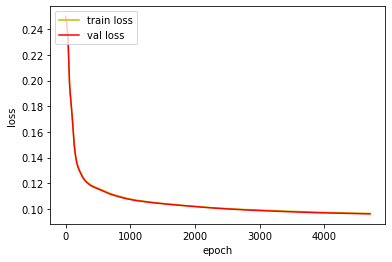

In [24]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, loss_ax = plt.subplots()

loss_ax.plot(hist['loss'], 'y', label='train loss')
loss_ax.plot(hist['val_loss'], 'r', label='val loss')

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')


loss_ax.legend(loc='upper left')


plt.show()

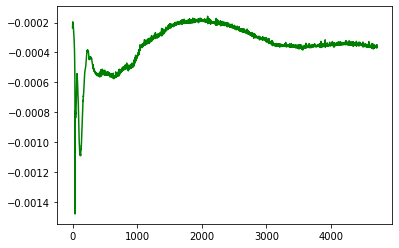

In [25]:
plt.plot([hist['val_loss'][i] - hist['loss'][i] for i in range(len(hist['loss']))], 'g', label='loss - val loss')
plt.show()

In [ ]:
y_pred = model.predict(X_test)
# print(y_pred[0])
# print(X_test.shape)
# print(((np.round(y_pred[0]) == X_test[0]) + (np.round(y_pred[1]) == X_test[1]))/ 2)
l = len(X_test)
acc = sum([np.round(y_pred[i])==X_test[i] for i in range(l)])/l
# acc = sum([y_pred[i]==X_test[i] for i in range(l)])/l
np.mean(acc)

In [84]:
model.save_weights(f'28_Autoencoder_{batch_size}_{learning_rate}_weight.h5')